# <span style="color:turquoise">**Detección de células redondas utilizando Yolo**</span>

## **Hardware**

**PC** Lenovo Idealpad Gaming3

**Procesador** AMD Ryzen 5 5600H with Radeon Graphics 3.3 GHz

	Velocidad de base:	3,30 GHz
	Sockets:	1
	Núcleos:	6
	Procesadores lógicos:	12
	Virtualización:	Habilitado
	Caché L1:	384 kB
	Caché L2:	3,0 MB
	Caché L3:	16,0 MB

**Gráficos dedicados** NVIDIA GeForce RTX 3050 Laptop 

	Versión del controlador:	31.0.15.5176
	Fecha del controlador:	01/03/2024
	Versión de DirectX:	12 (FL 12.1)
	Memoria de GPU dedicada	4,0 GB
	Memoria de GPU compartida	7,7 GB
	Memoria de GPU	11,7 GB
	
**RAM** 16 GB SODIMM DDR4 

	Velocidad:	3200 MHz
	Ranuras usadas:	2 de 2
	Factor de forma:	SODIMM

**Memoria estado sólido** SSD 512 GB 2210 NVMe PCIe Gen3 x4  Micron MTFDHBA512QFD

**Google Colab** 
	12.7 GB RAM, 15 GB RAM GPU Tesla T4, SSD 78.2 GB

In [ ]:
!nvidia-smi

## **Introducción**

En este TFM se pretende realizar un estudio del arte y entrenamiento de diferentes modelos (YOLO, Fast-RCNN, propio) para la detección de células y artefactos en imágenes médicas. Para esto, se aplican técnicas de visión por computador y aprendizaje profundo. Además, se realizará un exahustiva revisión de la bibliografía existente, mejora del dataset y análisis estadistico fundamentado en las diferentes métricas.

## **Dependencias**

In [ ]:
# %pip install -U ipywidgets jupyter
# %pip install ultralytics
# !pip install optuna

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import json
import optuna
import shutil
import pandas as pd
import torch

from ultralytics import YOLO
from lib.YOLO_lib import config, optuna_utils, plot_utils, kfold_utils, evaluation

In [3]:
print(f"Versión de PyTorch + CUDA: {torch.__version__}")
print(f"Diponible CUDA: {torch.cuda.is_available()}. \nDispositivo CUDA: {torch.cuda.get_device_name(0)}")

Versión de PyTorch + CUDA: 2.6.0+cu126
Diponible CUDA: True. 
Dispositivo CUDA: NVIDIA GeForce RTX 3050 Laptop GPU


## **Entrenamineto de los modelos YOLOv11 y YOLOv12**

### **Configuración**

Entrenamiento con modelos de YOLO con pesos de COCO

In [3]:
selected_model = "yolov12s"  # "custom" o "yolovXs"
model_dir = "yolo/yolo_models"
model_path = os.path.join(model_dir, f"{selected_model}.pt")
# model_path = os.path.join(model_dir, f"{selected_model}.yaml")

if selected_model not in config.models:
    if(selected_model == "custom"):
        model = YOLO(f"{selected_model}.yaml")
    else:
        model = YOLO(f"{selected_model}.pt")

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    if not os.path.exists(model_path):
        if(selected_model == "custom"):
            shutil.move(f"{selected_model}.yaml", model_path)
        else:
            shutil.move(f"{selected_model}.pt", model_path)
else:
    model = YOLO(config.models[selected_model])

Recuerda que si hemos descargado un nuevo modelo, debemos añadirlo al archivod e configuración.

In [4]:
storage_name = f"sqlite:///optuna/optuna_studies/{selected_model}.db"
best_params_path = f"optuna/optuna_studies/{selected_model}_best_params.json"
image_optuna_path = f'optuna/optuna_plots/optimization_{selected_model}.png'
model_output = f"final_model_{selected_model}"
model_output_kfold = model_output + "_kfold"
name_best_params = f"best_params_{selected_model}"

### **Optuna**

In [5]:
study = optuna.create_study(
    direction="maximize",  # Maximizar mAP@0.5:0.95
    study_name=selected_model,
    storage=storage_name,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed = config.SEED),  
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=10)
)

study.optimize(lambda trial: optuna_utils.optuna_objective(trial, model, selected_model), n_trials=config.N_TRIALS, timeout=None)

print("Número de trials completados:", len(study.trials))

with open(best_params_path, 'w') as f:
    json.dump(study.best_trial.params, f, indent=2)

[I 2025-08-24 13:19:54,722] A new study created in RDB with name: custom


New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005611516415334506, lrf=0.00892718030435363, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/custom.yaml, momentum=0.9097990912717108, mosaic=0, multi_scale

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 298 images, 18 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 146.040.9 MB/s, size: 94.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_custom_0\labels.jpg... 
optimizer: SGD(lr=0.0005611516415334506, momentum=0.9097990912717108) with parameter groups 76 weight(decay=0.0), 83 weight(decay=0.0003720743747291598), 82 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_custom_0
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.67G      6.848       30.7        4.8        120        704: 100%|██████████| 25/25 [00:39<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      3.64G      6.835      17.79      4.794        138        704: 100%|██████████| 25/25 [00:42<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.66G      6.856      12.32      4.617         88        704: 100%|██████████| 25/25 [00:40<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.67G      6.552       12.1       4.42        147        704: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.56G       6.81      10.36      4.637        129        704: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.72G       6.79      9.875      4.585        149        704: 100%|██████████| 25/25 [00:25<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      3.58G      6.801      9.111      4.537        107        704: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.58G      6.808      9.022       4.43        100        704: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.54G      6.744      9.758      4.359        127        704: 100%|██████████| 25/25 [00:27<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25       3.6G      6.805      8.716      4.284        175        704: 100%|██████████| 25/25 [00:28<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.65G      6.755      8.993      4.269        106        704: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      3.74G      6.787      9.526      4.218        100        704: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      3.67G      6.766      8.159      4.215        104        704: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.66G      6.715      7.716      4.176        119        704: 100%|██████████| 25/25 [00:16<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      3.52G      6.692      7.992      4.189        142        704: 100%|██████████| 25/25 [00:13<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      3.66G      6.774      7.954      4.115         68        704: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.63G      6.697      7.644      4.128        226        704: 100%|██████████| 25/25 [00:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.66G      6.694      7.386      4.141         54        704: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.65G      6.634      7.338      4.102        166        704: 100%|██████████| 25/25 [00:21<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      3.57G      6.604       6.77      4.111        114        704: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25       3.6G      6.607      6.722      4.103        141        704: 100%|██████████| 25/25 [00:20<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.66G      6.636      6.936      4.068         51        704: 100%|██████████| 25/25 [00:23<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.64G      6.623       6.96      4.075         59        704: 100%|██████████| 25/25 [00:29<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      3.68G      6.625      6.984      4.043        161        704: 100%|██████████| 25/25 [00:20<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.63G      6.561      6.653       4.06        145        704: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all         75        878          0          0          0          0



25 epochs completed in 0.190 hours.
Optimizer stripped from runs\detect\optuna_trial_custom_0\weights\last.pt, 22.7MB
Optimizer stripped from runs\detect\optuna_trial_custom_0\weights\best.pt, 22.7MB

Validating runs\detect\optuna_trial_custom_0\weights\best.pt...
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
custom summary (fused): 95 layers, 11,139,539 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


                   all         75        878          0          0          0          0
Speed: 0.4ms preprocess, 9.2ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs\detect\optuna_trial_custom_0


[I 2025-08-24 13:31:58,604] Trial 0 finished with value: 0.0 and parameters: {'lr0': 0.0005611516415334506, 'lrf': 0.00892718030435363, 'momentum': 0.9097990912717108, 'weight_decay': 0.00039687933304443713, 'optimizer': 'SGD', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 0 with value: 0.0.


New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005399484409787433, lrf=0.003991305878561679, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/custom.yaml, momentum=0.9062108866694067, mosaic=0, multi_scale

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 298 images, 18 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 446.2208.5 MB/s, size: 94.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_custom_1\labels.jpg... 
optimizer: SGD(lr=0.005399484409787433, momentum=0.9062108866694067) with parameter groups 76 weight(decay=0.0), 83 weight(decay=9.830050992369968e-05), 82 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_custom_1
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25       3.8G      6.564      6.716      4.073        120        704: 100%|██████████| 25/25 [00:41<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      3.68G      6.512      5.817      4.004        138        704: 100%|██████████| 25/25 [00:41<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all         75        878    0.00518    0.00114   0.000182   4.22e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.57G      6.262      5.032      3.948         88        704: 100%|██████████| 25/25 [00:33<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all         75        878    0.00535    0.00456   0.000562   0.000111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.63G      5.814      4.443      3.813        147        704: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

                   all         75        878      0.029     0.0137    0.00319   0.000716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.59G      5.032      3.439      3.445        129        704: 100%|██████████| 25/25 [00:17<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all         75        878     0.0471     0.0786     0.0102    0.00188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.72G      4.229      2.786      2.801        149        704: 100%|██████████| 25/25 [00:24<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

                   all         75        878     0.0784     0.0957     0.0268    0.00663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      3.63G      3.568      2.485      2.078        107        704: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

                   all         75        878      0.164      0.133     0.0602     0.0121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.61G      2.953      2.106      1.702        100        704: 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

                   all         75        878      0.132       0.17     0.0583     0.0131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.57G      2.515      1.928      1.493        127        704: 100%|██████████| 25/25 [00:12<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]

                   all         75        878      0.217      0.214      0.114     0.0285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      3.62G      2.296      1.826      1.404        175        704: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]

                   all         75        878      0.258       0.33      0.194     0.0444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.68G      2.069      1.741      1.301        106        704: 100%|██████████| 25/25 [00:17<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all         75        878      0.275      0.296       0.19     0.0444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      3.76G      2.024      1.723      1.244        100        704: 100%|██████████| 25/25 [00:25<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]

                   all         75        878      0.426      0.305      0.278      0.064

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25       3.7G      1.944      1.627       1.21        104        704: 100%|██████████| 25/25 [00:27<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all         75        878      0.429      0.364      0.317     0.0762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.68G      1.884      1.513      1.182        119        704: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

                   all         75        878      0.384      0.274      0.219     0.0453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      3.63G      1.795      1.479      1.134        142        704: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all         75        878      0.436      0.425      0.356     0.0923

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      3.62G      1.733      1.418      1.115         68        704: 100%|██████████| 25/25 [00:24<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all         75        878      0.397       0.33      0.254     0.0484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.72G      1.776      1.402      1.122        226        704: 100%|██████████| 25/25 [00:24<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

                   all         75        878       0.53      0.491      0.448      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.57G      1.739      1.382      1.107         54        704: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

                   all         75        878      0.603      0.497      0.502      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.58G      1.676      1.342      1.098        166        704: 100%|██████████| 25/25 [00:23<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

                   all         75        878      0.623      0.546      0.533      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      3.58G       1.64      1.271      1.096        114        704: 100%|██████████| 25/25 [00:25<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all         75        878      0.596      0.526        0.5       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.61G      1.626      1.242      1.085        141        704: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

                   all         75        878      0.616      0.528      0.508      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.69G      1.582      1.267      1.067         51        704: 100%|██████████| 25/25 [00:38<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all         75        878      0.602      0.555      0.518      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.59G      1.637      1.255      1.069         59        704: 100%|██████████| 25/25 [00:13<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all         75        878      0.682      0.614      0.636      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25       3.7G      1.579      1.242      1.059        161        704: 100%|██████████| 25/25 [00:14<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all         75        878      0.652      0.587       0.58      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.66G      1.545      1.224      1.058        145        704: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all         75        878      0.637      0.542      0.535      0.106



25 epochs completed in 0.185 hours.
Optimizer stripped from runs\detect\optuna_trial_custom_1\weights\last.pt, 22.7MB


[I 2025-08-24 13:43:40,890] Trial 1 finished with value: 0.1058936652641276 and parameters: {'lr0': 0.005399484409787433, 'lrf': 0.003991305878561679, 'momentum': 0.9062108866694067, 'weight_decay': 0.00010485387725194633, 'optimizer': 'SGD', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 1 with value: 0.1058936652641276.


New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0002310201887845295, lrf=0.0015254729458052604, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/custom.yaml, momentum=0.8456363364439307, mosaic=0, multi_sca

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 298 images, 18 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 164.443.8 MB/s, size: 94.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_custom_2\labels.jpg... 
optimizer: AdamW(lr=0.0002310201887845295, momentum=0.8456363364439307) with parameter groups 76 weight(decay=0.0), 83 weight(decay=0.0003138540289233688), 82 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_custom_2
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.91G      1.618      1.243      1.058        120        704: 100%|██████████| 25/25 [00:44<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all         75        878      0.667      0.576      0.601      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      3.73G       1.58      1.212      1.042        138        704: 100%|██████████| 25/25 [00:38<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all         75        878      0.396      0.343       0.23     0.0394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.69G      1.562      1.166      1.036         88        704: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]

                   all         75        878      0.682      0.657      0.663      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.74G      1.543      1.183      1.035        147        704: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all         75        878      0.515      0.501      0.395     0.0668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.76G      1.514      1.161      1.031        129        704: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all         75        878      0.654      0.558       0.57      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.77G      1.425      1.144      1.016        149        704: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

                   all         75        878      0.495      0.481      0.368     0.0636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      3.68G      1.483      1.133      1.018        107        704: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all         75        878      0.711      0.652      0.671       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.66G      1.483      1.119      1.018        100        704: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all         75        878      0.597      0.617      0.555      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.68G      1.414      1.086     0.9935        127        704: 100%|██████████| 25/25 [00:17<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all         75        878      0.722      0.662      0.692      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      3.63G      1.441      1.105       1.01        175        704: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all         75        878      0.678      0.671      0.647      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.72G      1.383       1.07     0.9928        106        704: 100%|██████████| 25/25 [00:24<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all         75        878      0.689      0.641      0.636      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25       3.8G      1.448      1.077     0.9997        100        704: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all         75        878      0.685      0.687      0.662      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      3.75G      1.438      1.097     0.9949        104        704: 100%|██████████| 25/25 [00:38<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all         75        878      0.711      0.711      0.718       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.73G      1.395      1.074     0.9949        119        704: 100%|██████████| 25/25 [00:26<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all         75        878      0.661      0.657      0.646      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      3.59G      1.336       1.05     0.9719        142        704: 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all         75        878      0.727      0.748      0.747      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      3.67G      1.343      1.044     0.9718         68        704: 100%|██████████| 25/25 [00:29<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all         75        878      0.662      0.622      0.608      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.77G      1.378      1.041     0.9825        226        704: 100%|██████████| 25/25 [00:26<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]

                   all         75        878      0.739      0.701      0.713      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.65G      1.409      1.036     0.9843         54        704: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]

                   all         75        878      0.749      0.727      0.755      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.63G       1.35      1.052      0.984        166        704: 100%|██████████| 25/25 [00:25<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

                   all         75        878      0.671      0.634      0.627      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      3.72G      1.347      1.037     0.9869        114        704: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all         75        878      0.744      0.731      0.755      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.73G       1.35      1.029     0.9856        141        704: 100%|██████████| 25/25 [00:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all         75        878      0.685      0.678      0.651      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.68G      1.332      1.041     0.9744         51        704: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         75        878      0.705       0.71      0.705      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.64G      1.392      1.065     0.9836         59        704: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

                   all         75        878      0.709      0.714      0.704      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      3.81G      1.369      1.052     0.9828        161        704: 100%|██████████| 25/25 [00:28<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all         75        878      0.723      0.723      0.725      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.71G      1.328       1.04     0.9786        145        704: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all         75        878      0.721       0.71      0.715      0.162



25 epochs completed in 0.203 hours.
Optimizer stripped from runs\detect\optuna_trial_custom_2\weights\last.pt, 22.7MB


[I 2025-08-24 13:56:28,727] Trial 2 finished with value: 0.16174210268769182 and parameters: {'lr0': 0.0002310201887845295, 'lrf': 0.0015254729458052604, 'momentum': 0.8456363364439307, 'weight_decay': 0.0003347776308515934, 'optimizer': 'AdamW', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 2 with value: 0.16174210268769182.


New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00019010245319870352, lrf=0.001959497205867916, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/custom.yaml, momentum=0.8549542764940538, mosaic=0, multi_sca

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 298 images, 18 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 606.8201.9 MB/s, size: 94.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_custom_3\labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 76 weight(decay=0.0), 83 weight(decay=0.0002679422874194002), 82 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_custom_3
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.81G      1.367      1.035     0.9786        120        704: 100%|██████████| 25/25 [00:35<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]

                   all         75        878      0.729      0.719      0.734      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      3.69G      1.348      1.046      0.978        138        704: 100%|██████████| 25/25 [00:39<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

                   all         75        878      0.728      0.694      0.702      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.62G      1.342      1.018     0.9748         88        704: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all         75        878      0.714      0.699      0.701      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.71G      1.335      1.033     0.9766        147        704: 100%|██████████| 25/25 [00:25<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all         75        878      0.716       0.69       0.69      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.67G      1.336      1.021       0.98        129        704: 100%|██████████| 25/25 [00:38<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all         75        878      0.716      0.702      0.703      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.73G      1.273      1.006     0.9695        149        704: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

                   all         75        878      0.726      0.717      0.722      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      3.65G      1.317       1.03     0.9767        107        704: 100%|██████████| 25/25 [00:14<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

                   all         75        878       0.72       0.71      0.711       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.59G       1.36      1.026     0.9808        100        704: 100%|██████████| 25/25 [00:11<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

                   all         75        878       0.73      0.711      0.719      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.59G      1.303     0.9975     0.9643        127        704: 100%|██████████| 25/25 [00:27<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all         75        878      0.729      0.715      0.724       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      3.63G      1.331      1.029     0.9776        175        704: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]

                   all         75        878      0.755      0.717      0.748      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.69G       1.27     0.9929     0.9624        106        704: 100%|██████████| 25/25 [00:29<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all         75        878      0.704      0.703      0.695      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      3.74G      1.346      1.017     0.9738        100        704: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all         75        878      0.703      0.684      0.672      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      3.75G       1.33      1.017     0.9715        104        704: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all         75        878      0.716      0.712      0.706      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.69G      1.308      1.006     0.9719        119        704: 100%|██████████| 25/25 [00:17<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all         75        878      0.724      0.722      0.721      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      3.59G      1.256     0.9962     0.9535        142        704: 100%|██████████| 25/25 [00:15<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

                   all         75        878      0.739      0.733      0.744      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25       3.7G      1.267     0.9778     0.9532         68        704: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all         75        878      0.723      0.716      0.716      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.74G      1.316     0.9939     0.9651        226        704: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

                   all         75        878      0.702      0.695      0.683      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.71G      1.344     0.9917     0.9694         54        704: 100%|██████████| 25/25 [00:17<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all         75        878      0.722      0.714      0.715      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.69G      1.302      1.005     0.9699        166        704: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all         75        878      0.722      0.716      0.717      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25       3.6G      1.296     0.9949     0.9726        114        704: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all         75        878      0.724      0.719      0.721      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.63G      1.304     0.9934     0.9734        141        704: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all         75        878      0.716      0.716      0.713       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.59G      1.296     0.9965     0.9649         51        704: 100%|██████████| 25/25 [00:14<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all         75        878      0.718      0.711      0.709      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.68G      1.368      1.033     0.9781         59        704: 100%|██████████| 25/25 [00:16<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all         75        878      0.717      0.711      0.708      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      3.71G      1.352      1.026     0.9779        161        704: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

                   all         75        878      0.712      0.705      0.703      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.68G      1.314      1.019     0.9741        145        704: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all         75        878      0.713      0.707      0.704      0.154



25 epochs completed in 0.180 hours.
Optimizer stripped from runs\detect\optuna_trial_custom_3\weights\last.pt, 22.7MB


[I 2025-08-24 14:07:44,923] Trial 3 finished with value: 0.15416501189365325 and parameters: {'lr0': 0.00019010245319870352, 'lrf': 0.001959497205867916, 'momentum': 0.8549542764940538, 'weight_decay': 0.0002858051065806936, 'optimizer': 'SGD', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 2 with value: 0.16174210268769182.


New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0015304852121831463, lrf=0.001112885317490573, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/custom.yaml, momentum=0.8911317277852158, mosaic=0, multi_scal

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 298 images, 18 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 567.7148.4 MB/s, size: 94.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_custom_4\labels.jpg... 
optimizer: AdamW(lr=0.0015304852121831463, momentum=0.8911317277852158) with parameter groups 76 weight(decay=0.0), 83 weight(decay=0.0001388338604997675), 82 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_custom_4
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.91G      1.456      1.157     0.9946        120        704: 100%|██████████| 25/25 [00:38<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all         75        878      0.722      0.728      0.753      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      3.68G      1.448      1.131     0.9943        138        704: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all         75        878      0.618      0.614      0.565      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.64G      1.437      1.128     0.9892         88        704: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all         75        878      0.646      0.697      0.678      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.74G      1.391      1.123     0.9774        147        704: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

                   all         75        878      0.775      0.752      0.799       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.64G       1.44      1.098     0.9948        129        704: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         75        878      0.625      0.557      0.537      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.77G        1.4      1.101     0.9797        149        704: 100%|██████████| 25/25 [00:30<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all         75        878      0.668      0.716      0.685      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      3.68G      1.393      1.108     0.9721        107        704: 100%|██████████| 25/25 [00:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all         75        878      0.793      0.753      0.805      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.65G      1.392      1.064     0.9719        100        704: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

                   all         75        878      0.735      0.726      0.722      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.68G       1.32      1.025     0.9525        127        704: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all         75        878      0.737      0.759      0.748       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      3.61G      1.356      1.028     0.9622        175        704: 100%|██████████| 25/25 [00:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all         75        878      0.713      0.722      0.689      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.71G      1.241      0.949     0.9364        106        704: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all         75        878      0.521      0.517      0.375     0.0561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25       3.8G      1.341      0.984     0.9516        100        704: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]

                   all         75        878      0.801      0.798      0.848      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      3.75G       1.32      1.037     0.9505        104        704: 100%|██████████| 25/25 [00:17<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all         75        878      0.233      0.339      0.125     0.0181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.73G       1.28      1.024      0.944        119        704: 100%|██████████| 25/25 [00:17<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

                   all         75        878      0.795      0.798       0.84      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      3.59G      1.203     0.9702     0.9232        142        704: 100%|██████████| 25/25 [00:11<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

                   all         75        878      0.827      0.794      0.854        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      3.67G       1.23     0.9301     0.9226         68        704: 100%|██████████| 25/25 [00:11<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all         75        878      0.617      0.626       0.53     0.0784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.77G      1.257     0.9296     0.9286        226        704: 100%|██████████| 25/25 [00:24<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]

                   all         75        878      0.795      0.764      0.794      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.65G      1.258      0.948     0.9271         54        704: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

                   all         75        878      0.781      0.765      0.787      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.63G      1.207      0.959     0.9281        166        704: 100%|██████████| 25/25 [00:26<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

                   all         75        878      0.746      0.674      0.686      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      3.73G      1.227     0.9392     0.9333        114        704: 100%|██████████| 25/25 [00:23<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

                   all         75        878      0.753      0.755       0.79      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.72G       1.21      0.936     0.9296        141        704: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

                   all         75        878      0.789      0.744      0.771      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.67G       1.17     0.9143     0.9132         51        704: 100%|██████████| 25/25 [00:13<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

                   all         75        878      0.732      0.683      0.663      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.63G      1.269     0.9474     0.9327         59        704: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all         75        878      0.802      0.803      0.836      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25       3.8G      1.228     0.9345     0.9236        161        704: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

                   all         75        878      0.818      0.786      0.837      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.71G      1.166     0.9175      0.919        145        704: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

                   all         75        878      0.777      0.741      0.762      0.157



25 epochs completed in 0.158 hours.
Optimizer stripped from runs\detect\optuna_trial_custom_4\weights\last.pt, 22.7MB


[I 2025-08-24 14:17:54,301] Trial 4 finished with value: 0.15691474155619053 and parameters: {'lr0': 0.0015304852121831463, 'lrf': 0.001112885317490573, 'momentum': 0.8911317277852158, 'weight_decay': 0.00014808945119975197, 'optimizer': 'AdamW', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 2 with value: 0.16174210268769182.


New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.004138040112561018, lrf=0.0020165721691808598, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/custom.yaml, momentum=0.8146508171009577, mosaic=0, multi_scal

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 298 images, 18 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 166.143.6 MB/s, size: 94.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_custom_5\labels.jpg... 
optimizer: AdamW(lr=0.004138040112561018, momentum=0.8146508171009577) with parameter groups 76 weight(decay=0.0), 83 weight(decay=0.00045311068429579364), 82 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_custom_5
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.95G      1.368      1.113     0.9535        120        704: 100%|██████████| 25/25 [00:44<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all         75        878      0.594      0.668      0.625      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      3.73G      1.372      1.071      0.954        138        704: 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all         75        878      0.429    0.00342    0.00403    0.00108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.65G      1.325      1.022     0.9413         88        704: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all         75        878      0.239     0.0957     0.0825     0.0296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.74G      1.425      1.053     0.9696        147        704: 100%|██████████| 25/25 [00:12<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

                   all         75        878    0.00576      0.116    0.00877    0.00419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.76G      1.441      1.149     0.9784        129        704: 100%|██████████| 25/25 [00:27<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all         75        878      0.537      0.469      0.406     0.0706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.77G       1.37       1.22     0.9623        149        704: 100%|██████████| 25/25 [00:35<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

                   all         75        878      0.427      0.486      0.288     0.0435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      3.68G      1.348      1.106     0.9636        107        704: 100%|██████████| 25/25 [00:29<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

                   all         75        878      0.733      0.805       0.83      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.66G      1.261     0.9478     0.9322        100        704: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all         75        878        0.8      0.814      0.856      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.68G      1.227     0.9084      0.921        127        704: 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all         75        878      0.785      0.821      0.857      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      3.61G      1.238      0.927     0.9349        175        704: 100%|██████████| 25/25 [00:11<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all         75        878      0.786      0.789      0.822      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.72G       1.24     0.9961     0.9304        106        704: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all         75        878      0.834      0.777      0.864      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      3.81G      1.177     0.8984     0.9123        100        704: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

                   all         75        878       0.82      0.797      0.874      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      3.75G      1.143     0.8434     0.9102        104        704: 100%|██████████| 25/25 [00:33<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all         75        878       0.84      0.813      0.877      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.74G      1.091     0.8074     0.9039        119        704: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all         75        878      0.822      0.834      0.882      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      3.69G      1.062     0.7907     0.8921        142        704: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all         75        878      0.808      0.848      0.885      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      3.63G      1.052     0.7683     0.8869         68        704: 100%|██████████| 25/25 [00:17<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]

                   all         75        878      0.823      0.818      0.887      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.78G      1.045     0.8004     0.8872        226        704: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all         75        878      0.811      0.829      0.886      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.66G      1.086     0.7881     0.8907         54        704: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         75        878      0.816       0.82      0.887      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.64G      1.011     0.7698     0.8856        166        704: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all         75        878      0.835      0.788       0.87      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      3.74G      0.947      0.732     0.8815        114        704: 100%|██████████| 25/25 [00:20<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

                   all         75        878      0.848      0.817      0.893      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.72G      1.002     0.7257     0.8875        141        704: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all         75        878      0.832      0.825       0.89      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.68G     0.9769     0.7286     0.8745         51        704: 100%|██████████| 25/25 [00:33<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

                   all         75        878      0.852      0.834      0.899      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.64G     0.9466     0.7178     0.8762         59        704: 100%|██████████| 25/25 [00:27<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all         75        878      0.832       0.83      0.899      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      3.81G     0.9551     0.7197     0.8785        161        704: 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all         75        878      0.832      0.835      0.899      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.71G     0.9096     0.6975     0.8743        145        704: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all         75        878      0.821      0.845      0.899      0.621



25 epochs completed in 0.184 hours.
Optimizer stripped from runs\detect\optuna_trial_custom_5\weights\last.pt, 22.7MB


[I 2025-08-24 14:29:34,665] Trial 5 finished with value: 0.6210960070816265 and parameters: {'lr0': 0.004138040112561018, 'lrf': 0.0020165721691808598, 'momentum': 0.8146508171009577, 'weight_decay': 0.0004833180632488466, 'optimizer': 'AdamW', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 5 with value: 0.6210960070816265.


New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00011715937392307068, lrf=0.008115595675970505, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/custom.yaml, momentum=0.8388169972400026, mosaic=0, multi_sca

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 298 images, 18 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 351.043.5 MB/s, size: 94.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_custom_6\labels.jpg... 
optimizer: AdamW(lr=0.00011715937392307068, momentum=0.8388169972400026) with parameter groups 76 weight(decay=0.0), 83 weight(decay=0.0004310161673186406), 82 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_custom_6
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.87G     0.9859     0.7318      0.877        120        704: 100%|██████████| 25/25 [00:28<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all         75        878       0.82      0.842        0.9      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      3.73G     0.9257     0.7081     0.8705        138        704: 100%|██████████| 25/25 [00:28<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all         75        878      0.836      0.828      0.899      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.65G     0.9101     0.6924     0.8666         88        704: 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all         75        878      0.817      0.847      0.899       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.74G      0.893     0.6924     0.8642        147        704: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all         75        878      0.829       0.84      0.901      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.75G     0.9143     0.6824     0.8757        129        704: 100%|██████████| 25/25 [00:23<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all         75        878      0.827      0.838      0.902      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.76G     0.8829     0.6685     0.8684        149        704: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all         75        878      0.821      0.842      0.899      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      3.68G     0.8764     0.6853     0.8679        107        704: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all         75        878      0.827      0.843      0.899      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.65G     0.8941     0.6683     0.8662        100        704: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all         75        878      0.827      0.841      0.901      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.68G     0.8843     0.6666     0.8611        127        704: 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all         75        878      0.827      0.842      0.901      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      3.61G     0.8723     0.6592     0.8668        175        704: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]

                   all         75        878      0.832      0.846      0.902      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.72G      0.904     0.6719     0.8686        106        704: 100%|██████████| 25/25 [00:12<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all         75        878      0.836      0.837      0.901      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25       3.8G     0.8609     0.6706     0.8593        100        704: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all         75        878      0.834      0.844      0.902      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      3.75G     0.8684     0.6586     0.8624        104        704: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all         75        878      0.828      0.846      0.902       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.73G     0.8559      0.641     0.8657        119        704: 100%|██████████| 25/25 [00:25<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

                   all         75        878      0.833      0.841      0.902      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      3.59G     0.8524     0.6559     0.8565        142        704: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

                   all         75        878      0.845      0.834      0.902      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      3.63G     0.8552     0.6463     0.8586         68        704: 100%|██████████| 25/25 [00:30<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all         75        878      0.849      0.829      0.902      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.77G     0.8591     0.6527     0.8587        226        704: 100%|██████████| 25/25 [00:20<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all         75        878      0.849      0.825      0.903      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.65G      0.864     0.6467      0.862         54        704: 100%|██████████| 25/25 [00:23<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all         75        878      0.849      0.821      0.903      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.63G     0.8484     0.6463     0.8603        166        704: 100%|██████████| 25/25 [00:23<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all         75        878       0.85       0.82      0.903      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      3.73G     0.8337      0.634      0.861        114        704: 100%|██████████| 25/25 [00:25<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all         75        878      0.845      0.827      0.904      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.72G     0.8656     0.6478     0.8672        141        704: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

                   all         75        878      0.845      0.829      0.903      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.67G     0.8491     0.6498     0.8565         51        704: 100%|██████████| 25/25 [00:14<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all         75        878      0.845      0.824      0.904      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.63G     0.8692     0.6616     0.8638         59        704: 100%|██████████| 25/25 [00:16<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

                   all         75        878       0.85      0.821      0.904      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25       3.8G     0.8619     0.6613     0.8631        161        704: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all         75        878      0.852      0.823      0.904       0.63

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.71G     0.8552     0.6615     0.8644        145        704: 100%|██████████| 25/25 [00:16<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all         75        878      0.849      0.823      0.904      0.636



25 epochs completed in 0.170 hours.
Optimizer stripped from runs\detect\optuna_trial_custom_6\weights\last.pt, 22.7MB


[I 2025-08-24 14:40:22,244] Trial 6 finished with value: 0.6356357586519109 and parameters: {'lr0': 0.00011715937392307068, 'lrf': 0.008115595675970505, 'momentum': 0.8388169972400026, 'weight_decay': 0.0004597505784732166, 'optimizer': 'AdamW', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 6 with value: 0.6356357586519109.


New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00023426581058204064, lrf=0.009323621351781481, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/custom.yaml, momentum=0.9162699235041671, mosaic=0, multi_sca

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 298 images, 18 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 163.852.5 MB/s, size: 94.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_custom_7\labels.jpg... 
optimizer: AdamW(lr=0.00023426581058204064, momentum=0.9162699235041671) with parameter groups 76 weight(decay=0.0), 83 weight(decay=0.0008155868557981239), 82 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_custom_7
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.95G     0.9532     0.7065     0.8698        120        704: 100%|██████████| 25/25 [00:44<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all         75        878      0.832      0.833      0.897       0.63

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      3.73G     0.9184     0.6994     0.8668        138        704: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]

                   all         75        878       0.83      0.844      0.899      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.65G     0.8906     0.6795     0.8615         88        704: 100%|██████████| 25/25 [00:11<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all         75        878      0.832      0.841        0.9      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.74G     0.8872     0.6855     0.8601        147        704: 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

                   all         75        878      0.838      0.837      0.903      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.75G     0.9027     0.6752     0.8707        129        704: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all         75        878      0.871      0.809      0.902       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.76G     0.8714     0.6544     0.8628        149        704: 100%|██████████| 25/25 [00:24<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all         75        878      0.857      0.814        0.9      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      3.68G     0.8641     0.6765     0.8624        107        704: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all         75        878      0.836      0.836        0.9      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.65G     0.8766     0.6524     0.8612        100        704: 100%|██████████| 25/25 [00:21<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all         75        878      0.842      0.821      0.902      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.68G       0.87     0.6531     0.8571        127        704: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all         75        878      0.827      0.847      0.904       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25       3.6G     0.8592     0.6442     0.8634        175        704: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all         75        878       0.83      0.855      0.904      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.71G      0.893     0.6561     0.8647        106        704: 100%|██████████| 25/25 [00:11<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all         75        878      0.836      0.846      0.902      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      3.79G     0.8469      0.656     0.8555        100        704: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]

                   all         75        878      0.834      0.846      0.904      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      3.75G     0.8534     0.6432     0.8584        104        704: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all         75        878      0.834      0.847      0.905      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.73G     0.8463     0.6292     0.8623        119        704: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

                   all         75        878      0.864      0.822      0.906      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      3.69G      0.842     0.6377     0.8526        142        704: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all         75        878      0.877      0.808      0.905      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      3.66G     0.8416     0.6303     0.8545         68        704: 100%|██████████| 25/25 [00:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

                   all         75        878      0.856      0.821      0.905      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.76G     0.8557       0.64     0.8551        226        704: 100%|██████████| 25/25 [00:14<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all         75        878      0.858      0.828      0.906      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.64G     0.8506     0.6301     0.8572         54        704: 100%|██████████| 25/25 [00:17<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all         75        878      0.848      0.838      0.906      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.62G     0.8356       0.63      0.856        166        704: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all         75        878      0.835      0.847      0.905      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      3.72G      0.825     0.6187     0.8572        114        704: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all         75        878       0.83      0.849      0.905       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.72G     0.8644     0.6351     0.8631        141        704: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all         75        878      0.838      0.847      0.906      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.67G     0.8367     0.6341     0.8518         51        704: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all         75        878      0.835      0.851      0.907      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.63G     0.8544     0.6441     0.8593         59        704: 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all         75        878      0.856      0.828      0.907      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      3.82G     0.8443     0.6419     0.8578        161        704: 100%|██████████| 25/25 [00:13<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all         75        878      0.855      0.832      0.907      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25       3.7G     0.8406     0.6424       0.86        145        704: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all         75        878      0.856       0.83      0.907      0.659



25 epochs completed in 0.156 hours.
Optimizer stripped from runs\detect\optuna_trial_custom_7\weights\last.pt, 22.7MB


[I 2025-08-24 14:50:24,179] Trial 7 finished with value: 0.6585467676126389 and parameters: {'lr0': 0.00023426581058204064, 'lrf': 0.009323621351781481, 'momentum': 0.9162699235041671, 'weight_decay': 0.0008699593128513321, 'optimizer': 'AdamW', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 7 with value: 0.6585467676126389.


New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00015030900645056822, lrf=0.0015703008378806713, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/custom.yaml, momentum=0.8067840933365807, mosaic=0, multi_sc

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 298 images, 18 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 188.277.4 MB/s, size: 94.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_custom_8\labels.jpg... 
optimizer: AdamW(lr=0.00015030900645056822, momentum=0.8067840933365807) with parameter groups 76 weight(decay=0.0), 83 weight(decay=0.00019829036270330237), 82 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_custom_8
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.96G     0.9085     0.6771     0.8622        120        704: 100%|██████████| 25/25 [00:40<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]

                   all         75        878       0.86       0.82      0.904      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      3.69G     0.8697     0.6575     0.8588        138        704: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

                   all         75        878      0.829      0.853      0.904      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.62G     0.8692     0.6479     0.8565         88        704: 100%|██████████| 25/25 [00:20<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         75        878      0.835      0.844      0.902      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.68G     0.8454     0.6465     0.8536        147        704: 100%|██████████| 25/25 [00:24<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

                   all         75        878      0.854      0.828      0.906      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.63G       0.86     0.6342     0.8637        129        704: 100%|██████████| 25/25 [00:19<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all         75        878      0.849      0.827      0.904      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.78G     0.8421     0.6258     0.8582        149        704: 100%|██████████| 25/25 [00:27<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all         75        878      0.828      0.842      0.901      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      3.69G     0.8378     0.6397     0.8589        107        704: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all         75        878      0.842      0.833      0.901      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.66G     0.8455     0.6285     0.8554        100        704: 100%|██████████| 25/25 [00:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all         75        878      0.833      0.849      0.903      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.68G     0.8424     0.6297      0.852        127        704: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

                   all         75        878       0.83      0.854      0.905      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      3.62G     0.8398     0.6216     0.8586        175        704: 100%|██████████| 25/25 [00:18<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all         75        878      0.852      0.839      0.908      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.72G     0.8684     0.6357     0.8589        106        704: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

                   all         75        878      0.852      0.838      0.908      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      3.81G     0.8277     0.6364     0.8504        100        704: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all         75        878      0.845      0.844      0.908      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      3.75G     0.8311     0.6246     0.8539        104        704: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

                   all         75        878      0.867      0.823      0.908      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.74G     0.8306      0.614     0.8579        119        704: 100%|██████████| 25/25 [00:21<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all         75        878      0.861      0.826      0.908      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25      3.69G     0.8239     0.6211     0.8485        142        704: 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all         75        878      0.858      0.833      0.907      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      3.74G     0.8261     0.6179     0.8507         68        704: 100%|██████████| 25/25 [00:26<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all         75        878      0.853      0.837      0.906       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.77G     0.8319     0.6234     0.8509        226        704: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]

                   all         75        878      0.849      0.842      0.907      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.62G     0.8306     0.6145     0.8528         54        704: 100%|██████████| 25/25 [00:18<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

                   all         75        878       0.85      0.838      0.907      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.73G     0.8212      0.616     0.8516        166        704: 100%|██████████| 25/25 [00:21<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all         75        878      0.849      0.841      0.907      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      3.65G     0.8135     0.6073     0.8537        114        704: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all         75        878       0.85      0.843      0.908      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.67G     0.8465     0.6195     0.8595        141        704: 100%|██████████| 25/25 [00:23<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all         75        878      0.847      0.844      0.908      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.75G     0.8198     0.6204     0.8487         51        704: 100%|██████████| 25/25 [00:20<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all         75        878      0.846      0.847      0.908      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.72G     0.8461     0.6334     0.8567         59        704: 100%|██████████| 25/25 [00:29<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

                   all         75        878      0.846      0.846      0.909      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      3.76G     0.8318     0.6322     0.8546        161        704: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all         75        878      0.848      0.843      0.909      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.71G     0.8274     0.6304     0.8571        145        704: 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all         75        878       0.85      0.841      0.908      0.659



25 epochs completed in 0.177 hours.
Optimizer stripped from runs\detect\optuna_trial_custom_8\weights\last.pt, 22.7MB


[I 2025-08-24 15:01:41,265] Trial 8 finished with value: 0.6586426310630665 and parameters: {'lr0': 0.00015030900645056822, 'lrf': 0.0015703008378806713, 'momentum': 0.8067840933365807, 'weight_decay': 0.00021150972021685588, 'optimizer': 'AdamW', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 8 with value: 0.6586426310630665.


New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005170191786366995, lrf=0.0019095652801045377, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/custom.yaml, momentum=0.8814044124737372, mosaic=0, multi_sca

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 298 images, 18 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 163.654.3 MB/s, size: 94.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_custom_9\labels.jpg... 
optimizer: AdamW(lr=0.0005170191786366995, momentum=0.8814044124737372) with parameter groups 76 weight(decay=0.0), 83 weight(decay=0.00012968671851768733), 82 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_custom_9
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.95G      0.902     0.6781     0.8598        120        704: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

                   all         75        878      0.856      0.827      0.907      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25      3.69G     0.8829     0.6665     0.8583        138        704: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

                   all         75        878      0.831      0.847      0.903      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.64G     0.8802     0.6522      0.857         88        704: 100%|██████████| 25/25 [00:13<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all         75        878       0.85       0.82      0.901      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.75G     0.8574     0.6501     0.8533        147        704: 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all         75        878      0.855      0.826      0.901      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25      3.76G     0.8722      0.631     0.8613        129        704: 100%|██████████| 25/25 [00:21<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all         75        878      0.841      0.828      0.897       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25      3.78G     0.8727     0.6328     0.8605        149        704: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all         75        878      0.863      0.812      0.902      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/25      3.69G     0.8652     0.6495     0.8594        107        704: 100%|██████████| 25/25 [00:27<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all         75        878       0.87      0.819      0.904      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/25      3.67G     0.8551     0.6259     0.8551        100        704: 100%|██████████| 25/25 [00:12<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all         75        878      0.872      0.826      0.909      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/25      3.69G     0.8684     0.6359     0.8544        127        704: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

                   all         75        878      0.864      0.824      0.909      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/25      3.62G     0.8642     0.6292       0.86        175        704: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all         75        878      0.854      0.837      0.908      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/25      3.73G     0.8749     0.6338     0.8579        106        704: 100%|██████████| 25/25 [00:16<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all         75        878      0.861      0.831       0.91      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/25      3.81G     0.8362     0.6389       0.85        100        704: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

                   all         75        878      0.859      0.836      0.911      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25      3.76G      0.846     0.6263     0.8544        104        704: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all         75        878      0.856      0.843      0.911      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/25      3.74G     0.8329     0.6191     0.8558        119        704: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all         75        878      0.871       0.83      0.912       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/25       3.6G     0.8257     0.6212     0.8469        142        704: 100%|██████████| 25/25 [00:14<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all         75        878      0.862      0.833      0.911      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/25      3.68G     0.8223     0.6073     0.8487         68        704: 100%|██████████| 25/25 [00:27<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

                   all         75        878      0.859      0.833      0.912      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25      3.78G     0.8488     0.6231       0.85        226        704: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

                   all         75        878      0.859      0.833      0.913      0.621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/25      3.66G     0.8302     0.6043     0.8503         54        704: 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all         75        878      0.853      0.836       0.91      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/25      3.64G     0.8141     0.6103     0.8487        166        704: 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all         75        878      0.858      0.835      0.911      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25      3.74G     0.8158      0.602     0.8507        114        704: 100%|██████████| 25/25 [00:21<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all         75        878      0.866      0.825      0.912      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/25      3.74G      0.837     0.6096     0.8552        141        704: 100%|██████████| 25/25 [00:20<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all         75        878      0.857      0.835      0.912      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/25      3.69G     0.8116     0.6077     0.8446         51        704: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all         75        878       0.86      0.836      0.913       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/25      3.65G      0.837     0.6209     0.8537         59        704: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all         75        878      0.861       0.84      0.914      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25      3.81G     0.8209     0.6176     0.8515        161        704: 100%|██████████| 25/25 [00:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all         75        878      0.864      0.834      0.913      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/25      3.72G     0.8112     0.6152     0.8526        145        704: 100%|██████████| 25/25 [00:25<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all         75        878      0.859      0.842      0.913      0.673



25 epochs completed in 0.180 hours.
Optimizer stripped from runs\detect\optuna_trial_custom_9\weights\last.pt, 22.7MB


[I 2025-08-24 15:13:08,166] Trial 9 finished with value: 0.67329967116709 and parameters: {'lr0': 0.0005170191786366995, 'lrf': 0.0019095652801045377, 'momentum': 0.8814044124737372, 'weight_decay': 0.00013833249975219982, 'optimizer': 'AdamW', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 9 with value: 0.67329967116709.


Número de trials completados: 10


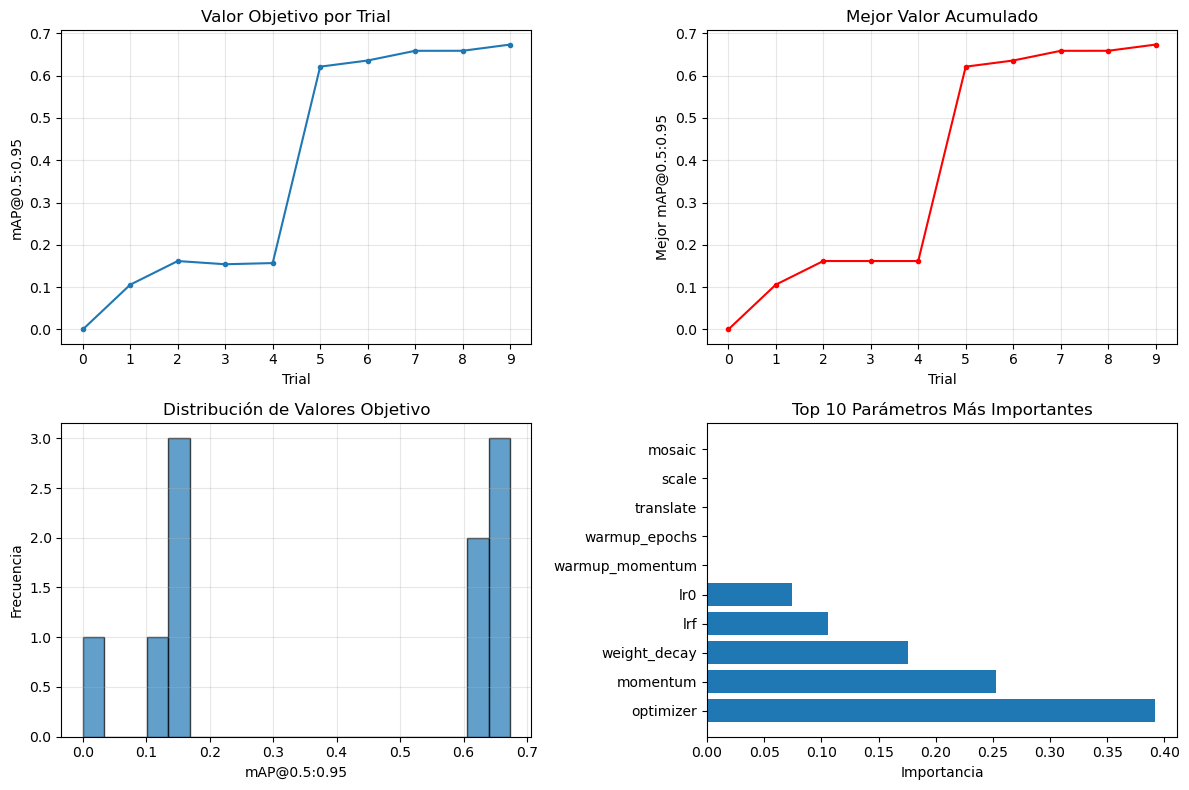

In [6]:
%matplotlib inline
optuna_utils.optuna_optimization_history(study, output_path=image_optuna_path)

In [7]:
with open(f"optuna/optuna_studies/{selected_model}_best_params.json", "r") as f:
    best_params = json.load(f)

print("Mejores hiperparámetros:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Mejores hiperparámetros:
  lr0: 0.0005170191786366995
  lrf: 0.0019095652801045377
  momentum: 0.8814044124737372
  weight_decay: 0.00013833249975219982
  optimizer: AdamW
  warmup_epochs: 5
  warmup_momentum: 0.75
  degrees: 45
  translate: 0.1
  scale: 0.06
  flipud: 0.5
  fliplr: 0.5
  mosaic: 0
  close_mosaic: 0


### **K-Fold Cross Validation**

Se concatena train y val para tener un dataset mayor para k-fold 373 imagenes en 4 folds.

In [5]:
params = getattr(config, name_best_params)
metrics_df = kfold_utils.train(model, params, model_output_kfold)


Entrenando fold_1 (1/4)
New https://pypi.org/project/ultralytics/8.3.185 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=7, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_1\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00023426581058204064, lrf=0.009323621351781481, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/yolo12s.pt, momentum=0.91

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_1\train\labels... 279 images, 19 backgrounds, 0 corrupt: 100%|██████████| 279/279 [00:00<00:00, 617.67it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_1\train\labels.cache


val: Fast image access  (ping: 0.10.0 ms, read: 8.31.8 MB/s, size: 102.2 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_1\val\labels... 94 images, 4 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<00:00, 442.71it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_1\val\labels.cache


Plotting labels to runs\detect\final_model_yolov12s_kfold\fold_1\labels.jpg... 
optimizer: AdamW(lr=0.00023426581058204064, momentum=0.9162699235041671) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00085636619858803), 119 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolov12s_kfold\fold_1
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      3.43G      2.093      2.796      1.185         48        704: 100%|██████████| 40/40 [00:26<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all         94       1160      0.639      0.483      0.541      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.66G      1.354      1.072      0.923         47        704: 100%|██████████| 40/40 [00:43<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]

                   all         94       1160       0.77      0.718      0.796      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.54G      1.285     0.9819     0.9007         88        704: 100%|██████████| 40/40 [00:48<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.14it/s]

                   all         94       1160      0.814      0.777      0.859      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      3.57G      1.125     0.9016     0.8773          6        704: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.92it/s]

                   all         94       1160      0.793      0.846      0.883      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      3.55G      1.084     0.8386     0.8662         72        704: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.72it/s]

                   all         94       1160      0.814      0.823      0.882       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      3.49G      1.079     0.7938     0.8702         61        704: 100%|██████████| 40/40 [00:27<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.02it/s]

                   all         94       1160      0.836       0.82      0.891      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      3.49G       1.06     0.7487     0.8629         91        704: 100%|██████████| 40/40 [00:42<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]

                   all         94       1160       0.81       0.85      0.895      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      3.48G      1.023     0.7664     0.8565         33        704: 100%|██████████| 40/40 [00:48<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]

                   all         94       1160      0.834      0.831      0.899      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      3.53G      1.049     0.7786      0.854         97        704: 100%|██████████| 40/40 [00:27<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]

                   all         94       1160      0.832      0.844      0.898      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      3.49G     0.9971     0.7291     0.8435        119        704: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]

                   all         94       1160      0.836      0.834      0.893      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      3.54G     0.9557     0.7103     0.8463         21        704: 100%|██████████| 40/40 [00:53<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]

                   all         94       1160       0.81      0.855        0.9       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      3.57G     0.9822     0.7123     0.8478        134        704: 100%|██████████| 40/40 [01:01<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.89it/s]

                   all         94       1160      0.812      0.859      0.904      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40       3.5G      1.042      0.759     0.8526         74        704: 100%|██████████| 40/40 [00:20<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]

                   all         94       1160      0.819      0.847      0.894      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      3.54G     0.9817     0.7035     0.8515         85        704: 100%|██████████| 40/40 [00:55<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all         94       1160      0.829      0.839      0.893      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      3.52G      1.003     0.7085      0.857        148        704: 100%|██████████| 40/40 [00:55<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.85it/s]

                   all         94       1160       0.82      0.859      0.901       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40       3.5G     0.9547     0.6792     0.8433         66        704: 100%|██████████| 40/40 [00:25<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

                   all         94       1160      0.822      0.851      0.892      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      3.51G     0.9833     0.7047     0.8501        109        704: 100%|██████████| 40/40 [00:52<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all         94       1160      0.807      0.862      0.899      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      3.54G     0.9122     0.6833     0.8379         49        704: 100%|██████████| 40/40 [00:56<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.76it/s]

                   all         94       1160      0.803      0.866      0.896      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      3.53G     0.8789     0.6752     0.8306        112        704: 100%|██████████| 40/40 [00:52<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.95it/s]

                   all         94       1160      0.819      0.854        0.9      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      3.61G     0.8607     0.6392     0.8319         96        704: 100%|██████████| 40/40 [00:16<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.99it/s]

                   all         94       1160      0.823      0.856      0.907      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      3.54G     0.8454     0.6275     0.8304        103        704: 100%|██████████| 40/40 [00:14<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.99it/s]

                   all         94       1160      0.823      0.867      0.905      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      3.51G     0.8283     0.6365     0.8284        118        704: 100%|██████████| 40/40 [00:20<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]

                   all         94       1160      0.825      0.871       0.91      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      3.51G     0.8304     0.6218     0.8243         76        704: 100%|██████████| 40/40 [00:47<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.93it/s]


                   all         94       1160      0.821       0.87       0.91      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      3.53G     0.8255     0.6313     0.8268         67        704: 100%|██████████| 40/40 [00:49<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.95it/s]

                   all         94       1160      0.812      0.868        0.9      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40       3.5G     0.8344      0.623     0.8256        110        704: 100%|██████████| 40/40 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]

                   all         94       1160      0.821      0.868      0.903      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      3.59G     0.8592     0.6149     0.8282        102        704: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]

                   all         94       1160      0.831      0.859      0.905      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      3.48G     0.8537      0.616     0.8347         78        704: 100%|██████████| 40/40 [00:33<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.55it/s]

                   all         94       1160      0.827      0.866      0.904      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      3.52G     0.8475     0.6195     0.8277        124        704: 100%|██████████| 40/40 [00:48<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.76it/s]

                   all         94       1160      0.824      0.863      0.907      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      3.53G     0.8228     0.6041     0.8247         64        704: 100%|██████████| 40/40 [00:29<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all         94       1160      0.839      0.852      0.905      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40       3.5G      0.803     0.5915     0.8241         41        704: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]

                   all         94       1160      0.835      0.848      0.905      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      3.53G     0.7751     0.5963     0.8192        119        704: 100%|██████████| 40/40 [00:48<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]

                   all         94       1160       0.83      0.853      0.906      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      3.54G     0.8046     0.5895     0.8256         65        704: 100%|██████████| 40/40 [01:00<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.85it/s]

                   all         94       1160      0.812      0.866      0.905      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      3.53G      0.799     0.5853     0.8289        107        704: 100%|██████████| 40/40 [00:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]

                   all         94       1160      0.833      0.852      0.909      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40       3.5G     0.7823     0.5945     0.8189        110        704: 100%|██████████| 40/40 [00:43<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]

                   all         94       1160      0.839      0.842      0.909      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      3.57G     0.8065     0.5858     0.8248         38        704: 100%|██████████| 40/40 [00:49<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all         94       1160      0.831       0.85      0.909        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      3.49G     0.7926     0.5835     0.8269         59        704: 100%|██████████| 40/40 [00:50<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all         94       1160      0.847      0.844      0.911      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      3.53G     0.7821     0.5799     0.8191         83        704: 100%|██████████| 40/40 [00:17<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]

                   all         94       1160      0.846      0.843      0.911        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      3.52G     0.7754      0.579     0.8178         44        704: 100%|██████████| 40/40 [00:27<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.74it/s]

                   all         94       1160      0.851      0.841       0.91      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      3.51G     0.7806     0.5684     0.8216         20        704: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]

                   all         94       1160      0.849      0.842      0.911      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40       3.5G     0.7669     0.5653     0.8151         36        704: 100%|██████████| 40/40 [00:38<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.63it/s]

                   all         94       1160      0.855      0.839       0.91      0.704



40 epochs completed in 0.467 hours.
Optimizer stripped from runs\detect\final_model_yolov12s_kfold\fold_1\weights\last.pt, 18.9MB
Optimizer stripped from runs\detect\final_model_yolov12s_kfold\fold_1\weights\best.pt, 18.9MB

Validating runs\detect\final_model_yolov12s_kfold\fold_1\weights\best.pt...
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]


                   all         94       1160      0.853      0.841       0.91      0.704
Speed: 0.4ms preprocess, 9.7ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\final_model_yolov12s_kfold\fold_1

Entrenando fold_2 (2/4)
New https://pypi.org/project/ultralytics/8.3.185 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=7, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_2\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, h

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_2\train\labels... 280 images, 19 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 571.44it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_2\train\labels.cache


val: Fast image access  (ping: 0.10.0 ms, read: 7.81.9 MB/s, size: 95.4 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_2\val\labels... 93 images, 4 backgrounds, 0 corrupt: 100%|██████████| 93/93 [00:00<00:00, 499.40it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_2\val\labels.cache


Plotting labels to runs\detect\final_model_yolov12s_kfold\fold_2\labels.jpg... 
optimizer: AdamW(lr=0.00023426581058204064, momentum=0.9162699235041671) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00085636619858803), 119 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolov12s_kfold\fold_2
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      3.69G     0.9519      0.716     0.8436         93        704: 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all         93       1279      0.805      0.886      0.913      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.53G     0.8844     0.6507     0.8396         78        704: 100%|██████████| 40/40 [01:08<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]

                   all         93       1279      0.829      0.885       0.92      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.48G     0.9187     0.6911     0.8365        117        704: 100%|██████████| 40/40 [00:54<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]

                   all         93       1279      0.848      0.874      0.919      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      3.53G     0.9045     0.6644      0.838        104        704: 100%|██████████| 40/40 [00:27<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.58it/s]

                   all         93       1279      0.833      0.882      0.917      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      3.55G     0.8793     0.6679     0.8267         22        704: 100%|██████████| 40/40 [00:43<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]

                   all         93       1279      0.859      0.865      0.916        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      3.49G     0.8507     0.6489     0.8294         93        704: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]

                   all         93       1279      0.838      0.879      0.916      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      3.54G     0.8359     0.6293     0.8258         99        704: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.10it/s]

                   all         93       1279      0.849      0.863      0.922      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      3.51G     0.8345     0.6222     0.8267        108        704: 100%|██████████| 40/40 [00:14<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.75it/s]

                   all         93       1279      0.841      0.872      0.921      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      3.48G     0.9288      0.659     0.8341        102        704: 100%|██████████| 40/40 [00:24<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]

                   all         93       1279      0.836      0.874       0.92      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      3.54G     0.8654     0.6318       0.83         38        704: 100%|██████████| 40/40 [00:43<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]

                   all         93       1279      0.849      0.868      0.919      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      3.56G     0.8373     0.6411     0.8291         40        704: 100%|██████████| 40/40 [00:34<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]

                   all         93       1279      0.863      0.857      0.922      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      3.47G     0.8554     0.6496     0.8308         58        704: 100%|██████████| 40/40 [00:48<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all         93       1279      0.861      0.867      0.921      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40       3.5G     0.9052     0.6416       0.84         56        704: 100%|██████████| 40/40 [00:21<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]

                   all         93       1279      0.864      0.866      0.921       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40       3.5G     0.8106     0.6101     0.8274         91        704: 100%|██████████| 40/40 [00:43<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.54it/s]

                   all         93       1279      0.855      0.862       0.92      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      3.54G     0.8062     0.6154     0.8246         26        704: 100%|██████████| 40/40 [00:57<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.02it/s]

                   all         93       1279      0.852      0.869      0.923      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      3.52G     0.8408     0.6302      0.829         94        704: 100%|██████████| 40/40 [00:54<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]

                   all         93       1279      0.856      0.867      0.922      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      3.59G     0.8013     0.6209     0.8229         92        704: 100%|██████████| 40/40 [00:17<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.14it/s]

                   all         93       1279      0.851      0.875      0.925      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      3.52G     0.8355     0.6309     0.8256         60        704: 100%|██████████| 40/40 [00:21<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.92it/s]

                   all         93       1279      0.851      0.875      0.924      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      3.59G     0.8162     0.6075     0.8245         98        704: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.73it/s]

                   all         93       1279       0.86       0.86      0.925      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      3.49G     0.7921     0.5878     0.8214         63        704: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.66it/s]

                   all         93       1279      0.862      0.858      0.924      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      3.53G     0.8141     0.5951     0.8237         98        704: 100%|██████████| 40/40 [00:52<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.44it/s]

                   all         93       1279      0.859      0.861      0.924      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      3.54G     0.7982      0.583     0.8231        107        704: 100%|██████████| 40/40 [00:17<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all         93       1279       0.85      0.874      0.923      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      3.55G     0.7943     0.5791     0.8325         54        704: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

                   all         93       1279      0.847      0.876      0.927      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      3.52G     0.7919     0.5782     0.8224         26        704: 100%|██████████| 40/40 [00:55<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]

                   all         93       1279      0.848      0.871      0.925      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      3.56G     0.7824     0.5705     0.8226        103        704: 100%|██████████| 40/40 [00:53<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

                   all         93       1279      0.848      0.879      0.926      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      3.51G     0.7829     0.5729     0.8157         48        704: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.79it/s]

                   all         93       1279      0.845      0.885      0.927      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      3.48G     0.7721     0.5696     0.8218        125        704: 100%|██████████| 40/40 [00:36<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.63it/s]

                   all         93       1279      0.846      0.887      0.927      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      3.55G     0.7617     0.5769     0.8163         60        704: 100%|██████████| 40/40 [00:38<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]

                   all         93       1279      0.849       0.88      0.927       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      3.55G      0.776     0.5747     0.8232        135        704: 100%|██████████| 40/40 [00:52<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]

                   all         93       1279      0.854      0.876      0.927      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      3.63G     0.7825     0.5648     0.8202         68        704: 100%|██████████| 40/40 [01:01<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.31it/s]

                   all         93       1279      0.845      0.881      0.927      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      3.49G     0.7679     0.5604     0.8192         79        704: 100%|██████████| 40/40 [00:54<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]

                   all         93       1279      0.844      0.881      0.927      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      3.54G     0.7671     0.5567     0.8202         91        704: 100%|██████████| 40/40 [01:32<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all         93       1279       0.86      0.871      0.928      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      3.54G     0.7794     0.5654     0.8191        114        704: 100%|██████████| 40/40 [00:18<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.77it/s]

                   all         93       1279      0.855      0.878      0.928      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40       3.5G      0.779     0.5628     0.8158         43        704: 100%|██████████| 40/40 [00:21<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.83it/s]

                   all         93       1279      0.863      0.876      0.928      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40       3.5G      0.783     0.5572      0.816        115        704: 100%|██████████| 40/40 [00:20<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.90it/s]

                   all         93       1279      0.858       0.88      0.927      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      3.48G     0.7526     0.5574      0.819        125        704: 100%|██████████| 40/40 [00:20<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.79it/s]

                   all         93       1279      0.851      0.881      0.927      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      3.51G     0.7617     0.5591     0.8154        105        704: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.94it/s]

                   all         93       1279      0.849      0.884      0.928      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      3.54G     0.7488     0.5504     0.8147         75        704: 100%|██████████| 40/40 [00:14<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.89it/s]

                   all         93       1279      0.852       0.88      0.927      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      3.59G      0.752     0.5516     0.8203        105        704: 100%|██████████| 40/40 [00:25<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.54it/s]

                   all         93       1279      0.857      0.877      0.928      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40       3.5G     0.7436     0.5421     0.8132         39        704: 100%|██████████| 40/40 [00:26<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]

                   all         93       1279      0.852      0.881      0.928      0.742



40 epochs completed in 0.469 hours.
Optimizer stripped from runs\detect\final_model_yolov12s_kfold\fold_2\weights\last.pt, 18.9MB
Optimizer stripped from runs\detect\final_model_yolov12s_kfold\fold_2\weights\best.pt, 18.9MB

Validating runs\detect\final_model_yolov12s_kfold\fold_2\weights\best.pt...
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]


                   all         93       1279      0.857       0.88      0.928      0.744
Speed: 0.3ms preprocess, 9.4ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\final_model_yolov12s_kfold\fold_2

Entrenando fold_3 (3/4)
New https://pypi.org/project/ultralytics/8.3.185 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=7, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_3\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, h

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_3\train\labels... 280 images, 13 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 717.86it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_3\train\labels.cache


val: Fast image access  (ping: 0.20.2 ms, read: 6.81.1 MB/s, size: 102.8 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_3\val\labels... 93 images, 10 backgrounds, 0 corrupt: 100%|██████████| 93/93 [00:00<00:00, 458.96it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_3\val\labels.cache


Plotting labels to runs\detect\final_model_yolov12s_kfold\fold_3\labels.jpg... 
optimizer: AdamW(lr=0.00023426581058204064, momentum=0.9162699235041671) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00085636619858803), 119 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolov12s_kfold\fold_3
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      3.58G     0.9848     0.6933     0.8418         84        704: 100%|██████████| 40/40 [00:14<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.87it/s]

                   all         93       1151      0.854      0.844      0.913       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.58G     0.8283     0.6181     0.8227         40        704: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]

                   all         93       1151      0.842      0.864      0.912      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.49G     0.8709     0.6362     0.8242        106        704: 100%|██████████| 40/40 [00:14<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.75it/s]

                   all         93       1151      0.842      0.857      0.911      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      3.51G     0.8807      0.636     0.8255        122        704: 100%|██████████| 40/40 [00:14<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.75it/s]

                   all         93       1151       0.83      0.868      0.907      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      3.49G     0.8047     0.5941     0.8177         50        704: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]

                   all         93       1151      0.809      0.898      0.912      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      3.48G     0.8142     0.6078     0.8232         61        704: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]

                   all         93       1151      0.832      0.858      0.907      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      3.52G     0.8161     0.6022     0.8237         78        704: 100%|██████████| 40/40 [00:41<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]

                   all         93       1151      0.833      0.868      0.904      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      3.53G      0.822     0.5953     0.8231        111        704: 100%|██████████| 40/40 [00:18<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]

                   all         93       1151      0.845      0.848      0.906      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      3.52G     0.8139     0.5939     0.8236         73        704: 100%|██████████| 40/40 [00:15<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]

                   all         93       1151      0.842      0.858      0.908      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40       3.5G     0.7789     0.5803     0.8192         89        704: 100%|██████████| 40/40 [00:42<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all         93       1151      0.833      0.874      0.911      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      3.55G     0.8151     0.5871      0.825         36        704: 100%|██████████| 40/40 [00:47<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.82it/s]

                   all         93       1151      0.839      0.864      0.906      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      3.56G     0.7906     0.5776     0.8214         41        704: 100%|██████████| 40/40 [00:59<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]

                   all         93       1151      0.837      0.863      0.908      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      3.49G     0.8093     0.5903     0.8225         40        704: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]

                   all         93       1151      0.817      0.879       0.91      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      3.54G     0.7957     0.5815     0.8147         78        704: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all         93       1151      0.828      0.869      0.906      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      3.54G     0.7811     0.5692     0.8151         76        704: 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all         93       1151      0.828      0.881      0.911      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      3.53G      0.794     0.5669     0.8202        102        704: 100%|██████████| 40/40 [00:28<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]

                   all         93       1151      0.853      0.845      0.913      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      3.54G     0.7785      0.566     0.8204         66        704: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]

                   all         93       1151      0.819      0.872      0.897      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      3.55G     0.7982     0.5692     0.8164         56        704: 100%|██████████| 40/40 [00:26<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]

                   all         93       1151      0.849      0.843      0.901      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      3.52G     0.7812     0.5687     0.8177        137        704: 100%|██████████| 40/40 [00:25<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]

                   all         93       1151      0.833      0.875       0.91      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      3.53G     0.7428     0.5591     0.8099         64        704: 100%|██████████| 40/40 [00:24<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]

                   all         93       1151      0.856      0.848      0.913      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      3.53G     0.7792     0.5704     0.8168         83        704: 100%|██████████| 40/40 [00:24<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]

                   all         93       1151      0.859      0.845      0.913      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      3.51G     0.7855     0.5754     0.8223        103        704: 100%|██████████| 40/40 [00:14<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.79it/s]

                   all         93       1151       0.85      0.849      0.911       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      3.55G     0.7861     0.5575     0.8244        107        704: 100%|██████████| 40/40 [00:24<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]

                   all         93       1151      0.847      0.858      0.912      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40       3.5G     0.7399     0.5542     0.8122         41        704: 100%|██████████| 40/40 [00:14<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.74it/s]

                   all         93       1151      0.857      0.853      0.912      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      3.56G     0.7548     0.5462     0.8117        165        704: 100%|██████████| 40/40 [00:26<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]

                   all         93       1151      0.852      0.864      0.912      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      3.53G     0.7522      0.546      0.813         99        704: 100%|██████████| 40/40 [00:24<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.94it/s]

                   all         93       1151      0.823      0.875      0.906      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      3.51G     0.7623     0.5429     0.8183         73        704: 100%|██████████| 40/40 [00:24<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]

                   all         93       1151      0.849       0.86      0.912      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      3.55G     0.7646      0.549     0.8154         62        704: 100%|██████████| 40/40 [00:15<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.26it/s]

                   all         93       1151      0.834      0.876      0.914      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      3.55G     0.7324     0.5438     0.8135         63        704: 100%|██████████| 40/40 [00:14<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

                   all         93       1151      0.837      0.868      0.913       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      3.53G     0.7564     0.5451     0.8181         66        704: 100%|██████████| 40/40 [00:14<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.00it/s]

                   all         93       1151      0.833      0.873      0.914       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      3.53G     0.7648     0.5382     0.8157         94        704: 100%|██████████| 40/40 [00:14<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]

                   all         93       1151      0.826      0.885      0.913      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      3.48G     0.7769      0.539      0.827         65        704: 100%|██████████| 40/40 [00:14<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]

                   all         93       1151      0.822      0.885      0.912      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      3.54G     0.7387     0.5327     0.8118         92        704: 100%|██████████| 40/40 [00:14<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]

                   all         93       1151      0.821      0.887      0.913      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      3.54G     0.7509      0.526     0.8113        118        704: 100%|██████████| 40/40 [00:14<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.85it/s]

                   all         93       1151      0.833      0.877      0.914      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      3.53G     0.7284     0.5235     0.8074         99        704: 100%|██████████| 40/40 [00:14<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]

                   all         93       1151      0.836      0.874      0.912      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      3.48G     0.7341     0.5264     0.8121        107        704: 100%|██████████| 40/40 [00:14<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]

                   all         93       1151      0.832      0.879      0.913      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      3.51G      0.733     0.5212     0.8128         78        704: 100%|██████████| 40/40 [00:14<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.58it/s]

                   all         93       1151      0.838      0.867      0.913      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      3.54G     0.7139     0.5242     0.8074        119        704: 100%|██████████| 40/40 [00:15<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]

                   all         93       1151      0.837      0.865      0.914      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      3.62G      0.718     0.5184     0.8118        130        704: 100%|██████████| 40/40 [00:22<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.81it/s]

                   all         93       1151      0.836      0.862      0.914      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      3.56G     0.7249     0.5091     0.8063         90        704: 100%|██████████| 40/40 [00:14<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.68it/s]

                   all         93       1151      0.827      0.877      0.913      0.727



40 epochs completed in 0.283 hours.
Optimizer stripped from runs\detect\final_model_yolov12s_kfold\fold_3\weights\last.pt, 18.9MB
Optimizer stripped from runs\detect\final_model_yolov12s_kfold\fold_3\weights\best.pt, 18.9MB

Validating runs\detect\final_model_yolov12s_kfold\fold_3\weights\best.pt...
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]


                   all         93       1151      0.837      0.864      0.914      0.731
Speed: 0.3ms preprocess, 8.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs\detect\final_model_yolov12s_kfold\fold_3

Entrenando fold_4 (4/4)
New https://pypi.org/project/ultralytics/8.3.185 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=7, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_4\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, h

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_4\train\labels... 280 images, 18 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 745.01it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_4\train\labels.cache


val: Fast image access  (ping: 0.10.0 ms, read: 7.51.7 MB/s, size: 95.7 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_4\val\labels... 93 images, 5 backgrounds, 0 corrupt: 100%|██████████| 93/93 [00:00<00:00, 508.68it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_4\val\labels.cache


Plotting labels to runs\detect\final_model_yolov12s_kfold\fold_4\labels.jpg... 
optimizer: AdamW(lr=0.00023426581058204064, momentum=0.9162699235041671) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00085636619858803), 119 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolov12s_kfold\fold_4
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      3.69G     0.8503     0.6244     0.8233         91        704: 100%|██████████| 40/40 [00:14<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.26it/s]

                   all         93       1222      0.844      0.873      0.916      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40       3.6G     0.8257     0.6285     0.8231         72        704: 100%|██████████| 40/40 [00:18<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.94it/s]

                   all         93       1222      0.846      0.894      0.914      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.54G       0.84     0.6391     0.8237        148        704: 100%|██████████| 40/40 [00:13<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.23it/s]

                   all         93       1222      0.858      0.877      0.916      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      3.56G     0.8027     0.5893       0.82         69        704: 100%|██████████| 40/40 [00:14<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.98it/s]

                   all         93       1222      0.871      0.871      0.919      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      3.53G     0.8151     0.5779     0.8184         41        704: 100%|██████████| 40/40 [00:14<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]

                   all         93       1222      0.858      0.883      0.917      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      3.49G     0.7798     0.5618     0.8187        102        704: 100%|██████████| 40/40 [00:14<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.92it/s]

                   all         93       1222       0.86      0.874      0.918      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      3.53G     0.7907     0.5815     0.8175        140        704: 100%|██████████| 40/40 [00:14<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.68it/s]

                   all         93       1222      0.859      0.856      0.917       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      3.49G     0.7843     0.5693     0.8156        100        704: 100%|██████████| 40/40 [00:14<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.78it/s]

                   all         93       1222      0.857      0.865      0.917      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      3.51G      0.781     0.5703      0.817         93        704: 100%|██████████| 40/40 [00:14<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]

                   all         93       1222      0.848      0.875      0.918      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      3.54G     0.8167     0.5768     0.8206        100        704: 100%|██████████| 40/40 [00:14<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]

                   all         93       1222      0.851      0.881      0.916      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      3.56G     0.7807     0.5741     0.8155         49        704: 100%|██████████| 40/40 [00:21<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.92it/s]

                   all         93       1222      0.858      0.877      0.917      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      3.57G     0.8107     0.5645     0.8178         47        704: 100%|██████████| 40/40 [00:19<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.77it/s]

                   all         93       1222      0.843      0.889      0.917      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      3.53G     0.8056     0.5764     0.8168         97        704: 100%|██████████| 40/40 [00:14<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.79it/s]

                   all         93       1222      0.854      0.885       0.92      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      3.52G     0.7774     0.5595     0.8146         60        704: 100%|██████████| 40/40 [00:14<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.91it/s]

                   all         93       1222      0.854      0.876      0.916      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      3.56G     0.7922     0.5761     0.8212         74        704: 100%|██████████| 40/40 [00:19<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]

                   all         93       1222      0.832      0.893      0.915      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      3.54G     0.7609     0.5588     0.8138         95        704: 100%|██████████| 40/40 [00:19<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.89it/s]

                   all         93       1222      0.847      0.887      0.915      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      3.59G     0.7511     0.5551     0.8126        110        704: 100%|██████████| 40/40 [00:14<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.87it/s]

                   all         93       1222      0.852      0.879      0.914      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      3.51G     0.7461     0.5631     0.8103        157        704: 100%|██████████| 40/40 [00:14<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.95it/s]

                   all         93       1222      0.842       0.89      0.918      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40       3.6G     0.7479     0.5446     0.8053         93        704: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.81it/s]

                   all         93       1222      0.853      0.879      0.917      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      3.49G     0.7489     0.5411     0.8078         94        704: 100%|██████████| 40/40 [00:14<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]

                   all         93       1222      0.861       0.87      0.919       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      3.53G     0.7458      0.537     0.8075         95        704: 100%|██████████| 40/40 [00:14<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.76it/s]

                   all         93       1222      0.854      0.877      0.919      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      3.49G     0.7679      0.537     0.8174        117        704: 100%|██████████| 40/40 [00:14<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]

                   all         93       1222      0.847      0.885      0.918      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      3.55G     0.7643     0.5436     0.8167         41        704: 100%|██████████| 40/40 [00:14<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.78it/s]

                   all         93       1222      0.853      0.877      0.916      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      3.53G     0.7276     0.5297     0.8103         67        704: 100%|██████████| 40/40 [00:15<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.31it/s]

                   all         93       1222      0.851      0.887      0.918      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      3.52G     0.7301     0.5306     0.8116        118        704: 100%|██████████| 40/40 [00:21<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]

                   all         93       1222      0.848      0.881      0.915       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      3.53G     0.7451     0.5373     0.8073         87        704: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]

                   all         93       1222      0.851      0.881      0.917       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      3.55G     0.7457       0.53     0.8116         81        704: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.63it/s]

                   all         93       1222       0.85      0.882      0.917      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      3.51G     0.7373     0.5321     0.8118        106        704: 100%|██████████| 40/40 [00:24<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]

                   all         93       1222      0.845      0.884      0.918      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      3.49G     0.7191     0.5243     0.8102         96        704: 100%|██████████| 40/40 [00:25<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.99it/s]

                   all         93       1222      0.858      0.869      0.915       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      3.53G     0.7383     0.5232      0.809         49        704: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.55it/s]

                   all         93       1222      0.853      0.871      0.913       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      3.51G      0.718      0.519     0.8076        104        704: 100%|██████████| 40/40 [00:24<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.88it/s]

                   all         93       1222      0.848      0.878      0.913      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      3.51G     0.7145     0.5126     0.8122         61        704: 100%|██████████| 40/40 [00:24<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]

                   all         93       1222      0.847       0.88      0.917      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      3.54G     0.7235      0.517     0.8107        158        704: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.85it/s]

                   all         93       1222      0.846       0.88      0.919      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      3.52G     0.7165     0.5148     0.8059         94        704: 100%|██████████| 40/40 [00:24<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all         93       1222      0.842      0.883      0.921      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      3.56G     0.7128     0.5085     0.8061        110        704: 100%|██████████| 40/40 [00:34<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.23it/s]

                   all         93       1222      0.849      0.879       0.92      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      3.55G     0.7084     0.5171     0.8128         88        704: 100%|██████████| 40/40 [00:43<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]

                   all         93       1222      0.855      0.872       0.92       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      3.54G     0.7135     0.5207     0.8037         97        704: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.90it/s]

                   all         93       1222      0.856       0.87       0.92      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      3.54G     0.6978     0.5022     0.8087         90        704: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.68it/s]

                   all         93       1222      0.857      0.867      0.919      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      3.48G     0.6977      0.514     0.8051         97        704: 100%|██████████| 40/40 [00:24<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.78it/s]

                   all         93       1222      0.862      0.863      0.921       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40       3.5G     0.6978     0.5013     0.8025         69        704: 100%|██████████| 40/40 [00:35<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.97it/s]

                   all         93       1222      0.863      0.862       0.92      0.739



40 epochs completed in 0.273 hours.
Optimizer stripped from runs\detect\final_model_yolov12s_kfold\fold_4\weights\last.pt, 18.9MB
Optimizer stripped from runs\detect\final_model_yolov12s_kfold\fold_4\weights\best.pt, 18.9MB

Validating runs\detect\final_model_yolov12s_kfold\fold_4\weights\best.pt...
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


                   all         93       1222      0.862      0.864      0.921       0.74
Speed: 0.4ms preprocess, 8.7ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs\detect\final_model_yolov12s_kfold\fold_4


In [6]:
kfold_utils.save_results(metrics_df, model_output_kfold)


Resultados por fold:
   fold  mAP50-95    mAP50  precision   recall
0     1   0.70427  0.91015    0.85467  0.83879
1     2   0.74396  0.92780    0.85667  0.87725
2     3   0.73051  0.91389    0.83693  0.86504
3     4   0.74044  0.92067    0.86194  0.86342

Promedio de métricas:
mAP50-95     0.729795
mAP50        0.918127
precision    0.852553
recall       0.861125
dtype: float64

Desviación estándar de métricas:
mAP50-95     0.017944
mAP50        0.007781
precision    0.010857
recall       0.016119
dtype: float64

Directorios temporales eliminados.


Gráfico guardado en: runs/detect/final_model_yolov12s_kfold\kfold_metrics.png


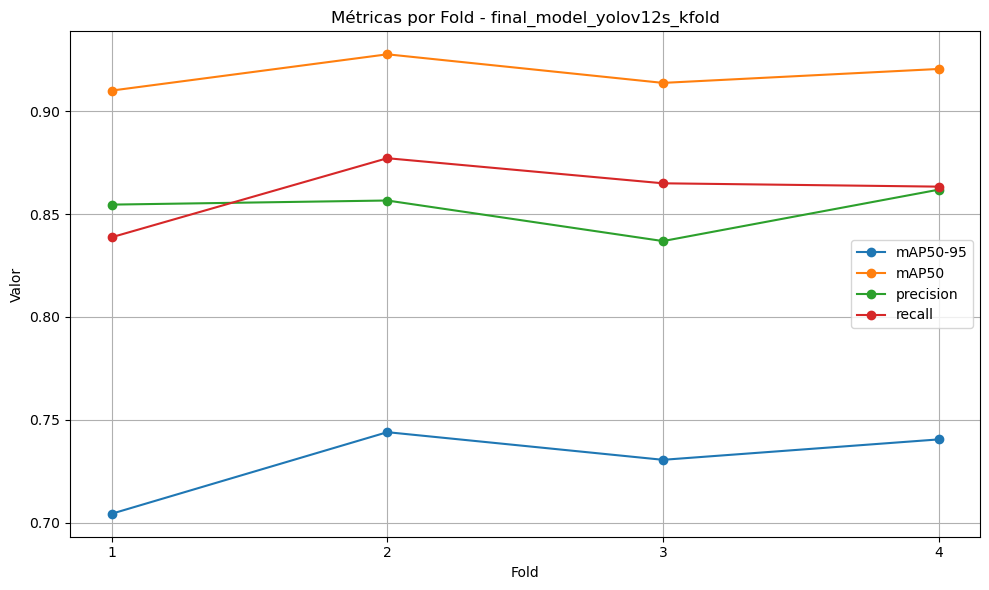

In [7]:
%matplotlib inline
kfold_utils.plot_kfold_metrics(metrics_df, model_output_kfold)

### **Train**

In [8]:
# params = getattr(config, name_best_params)
params = best_params

model.train(
    data="cells.yaml",
    epochs=config.EPOCH_TRAIN,   
    imgsz=config.IMGSZ,          
    batch=config.BATCH,           
    name=model_output,
    save=True,  
    seed=config.SEED,       
    **params
)

New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005170191786366995, lrf=0.0019095652801045377, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/custom.yaml, momentum=0.8814044124737372, mosaic=0, multi_sca

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 298 images, 18 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 488.3101.3 MB/s, size: 94.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs\detect\final_model_custom\labels.jpg... 
optimizer: AdamW(lr=0.0005170191786366995, momentum=0.8814044124737372) with parameter groups 76 weight(decay=0.0), 83 weight(decay=0.00012968671851768733), 82 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_custom
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40       3.7G     0.8771     0.6628      0.856        120        704: 100%|██████████| 25/25 [00:23<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all         75        878      0.869      0.828      0.909      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.71G     0.8505     0.6464      0.853        138        704: 100%|██████████| 25/25 [00:27<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all         75        878      0.832      0.849      0.906      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.68G     0.8513     0.6399     0.8516         88        704: 100%|██████████| 25/25 [00:24<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

                   all         75        878      0.851      0.838      0.907      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      3.78G      0.825     0.6261     0.8474        147        704: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all         75        878      0.863      0.834      0.912      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      3.67G     0.8463     0.6115     0.8556        129        704: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all         75        878      0.834      0.859       0.91      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40       3.8G     0.8378     0.6091      0.855        149        704: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all         75        878      0.859      0.818        0.9      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      3.72G     0.8342     0.6291      0.854        107        704: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all         75        878      0.859      0.825      0.907       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      3.69G     0.8376     0.6118     0.8504        100        704: 100%|██████████| 25/25 [00:14<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all         75        878       0.87      0.829       0.91      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      3.72G     0.8334     0.6184     0.8477        127        704: 100%|██████████| 25/25 [00:13<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

                   all         75        878      0.843      0.843      0.909      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      3.64G     0.8396     0.6134     0.8552        175        704: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

                   all         75        878      0.856      0.845      0.913      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      3.76G     0.8543      0.617     0.8525        106        704: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.02it/s]

                   all         75        878      0.862      0.835      0.912      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      3.83G     0.8342     0.6323     0.8468        100        704: 100%|██████████| 25/25 [00:24<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all         75        878      0.864      0.839      0.911      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      3.78G     0.8309     0.6119      0.851        104        704: 100%|██████████| 25/25 [00:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all         75        878       0.87      0.842      0.911      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      3.77G     0.8175     0.6085     0.8514        119        704: 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all         75        878       0.86      0.849      0.915      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      3.62G     0.8193     0.6131     0.8448        142        704: 100%|██████████| 25/25 [00:11<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all         75        878      0.857      0.846      0.914      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      3.71G     0.8153     0.6023     0.8459         68        704: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all         75        878      0.853      0.851      0.916      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40       3.8G     0.8643     0.6193     0.8495        226        704: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all         75        878      0.856      0.845      0.914       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      3.69G     0.8427     0.6065     0.8501         54        704: 100%|██████████| 25/25 [00:23<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all         75        878      0.841      0.846      0.909      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      3.67G     0.8135     0.6069     0.8466        166        704: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all         75        878      0.836      0.853      0.906      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      3.77G     0.8074     0.5921     0.8482        114        704: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all         75        878      0.833      0.858       0.91      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      3.76G     0.8555     0.6068     0.8555        141        704: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all         75        878      0.851      0.857      0.915      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      3.71G     0.8149      0.607     0.8429         51        704: 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all         75        878      0.879      0.838      0.916      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      3.67G     0.8294      0.613     0.8512         59        704: 100%|██████████| 25/25 [00:16<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all         75        878      0.875      0.834      0.917      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      3.84G     0.8158     0.6126     0.8488        161        704: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all         75        878      0.873      0.833      0.916      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      3.65G     0.8193     0.6123     0.8516        145        704: 100%|██████████| 25/25 [00:11<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

                   all         75        878      0.862      0.841      0.915      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      3.67G     0.8197     0.6039      0.848         92        704: 100%|██████████| 25/25 [00:13<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all         75        878      0.852      0.849      0.913       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      3.72G     0.8326     0.6082     0.8548        186        704: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all         75        878      0.846      0.858      0.911      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40       3.7G     0.8186     0.6027     0.8538        118        704: 100%|██████████| 25/25 [00:20<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all         75        878      0.842      0.859      0.913      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      3.74G     0.8191     0.5952     0.8518        157        704: 100%|██████████| 25/25 [00:20<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all         75        878      0.852      0.856      0.913      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      3.68G     0.8154     0.6019      0.847        128        704: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all         75        878      0.858      0.846      0.915      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      3.75G      0.839     0.5995     0.8503         74        704: 100%|██████████| 25/25 [00:16<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all         75        878      0.872      0.841      0.917      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      3.84G     0.8227     0.6038     0.8457        109        704: 100%|██████████| 25/25 [00:23<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]

                   all         75        878      0.865      0.843      0.916      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      3.76G     0.8162     0.6058     0.8476        205        704: 100%|██████████| 25/25 [00:18<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

                   all         75        878      0.857      0.855      0.916      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      3.67G     0.8151     0.5992     0.8521         59        704: 100%|██████████| 25/25 [00:16<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all         75        878      0.863      0.844      0.916      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      3.77G     0.8111     0.5867     0.8462        164        704: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all         75        878      0.859      0.846      0.917       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      3.73G     0.8081      0.593     0.8422        131        704: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]

                   all         75        878      0.858      0.849      0.916      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      3.73G     0.8313     0.6043     0.8471        109        704: 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all         75        878      0.859      0.848      0.917      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      3.73G     0.8015     0.5876     0.8436        109        704: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all         75        878      0.862      0.849      0.917      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      3.68G     0.8132      0.596     0.8527         62        704: 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all         75        878       0.86      0.849      0.917      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      3.76G     0.7863     0.5843      0.845        233        704: 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all         75        878      0.864      0.851      0.917      0.669



40 epochs completed in 0.263 hours.
Optimizer stripped from runs\detect\final_model_custom\weights\last.pt, 22.7MB
Optimizer stripped from runs\detect\final_model_custom\weights\best.pt, 22.7MB

Validating runs\detect\final_model_custom\weights\best.pt...
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
custom summary (fused): 95 layers, 11,139,539 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


                   all         75        878       0.86      0.849      0.917      0.692
Speed: 0.4ms preprocess, 8.3ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs\detect\final_model_custom


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000182F447CC90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

### **Train Plots**

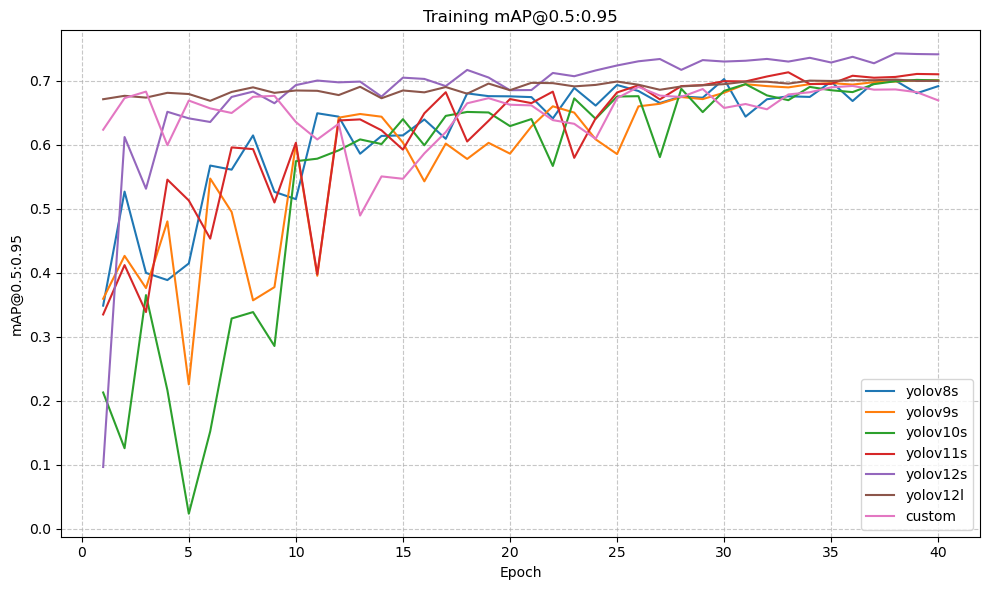

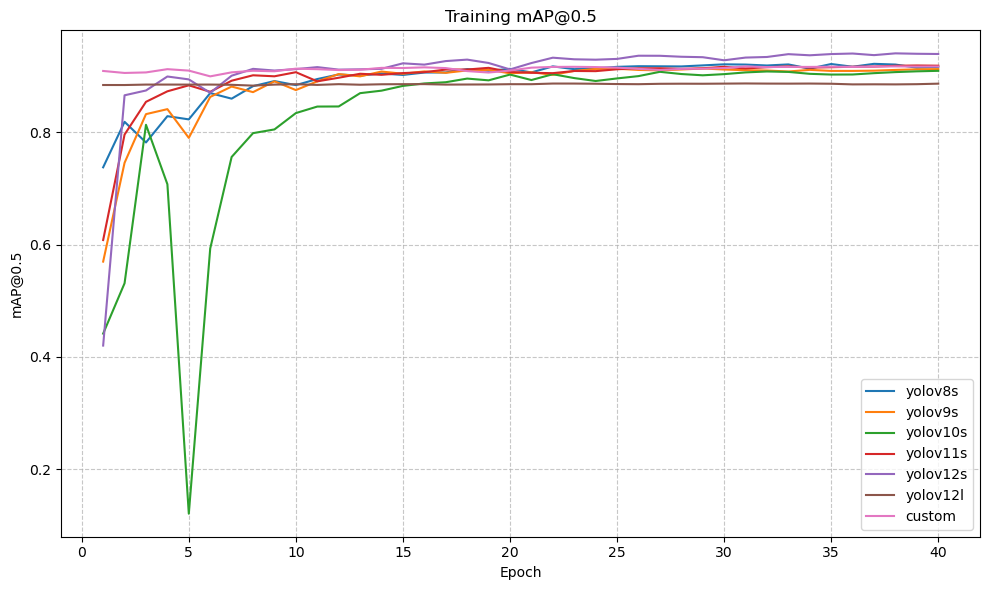

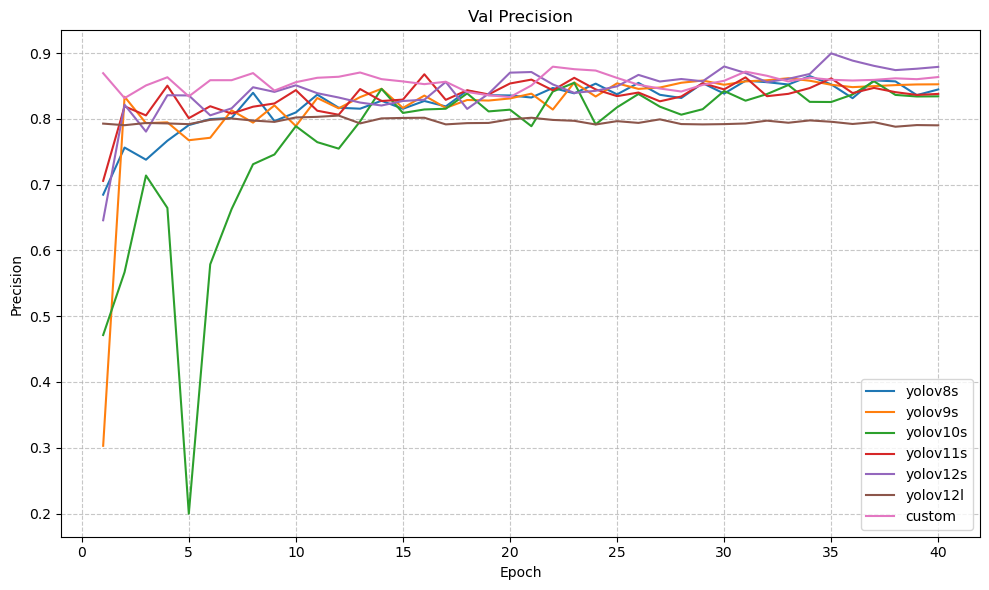

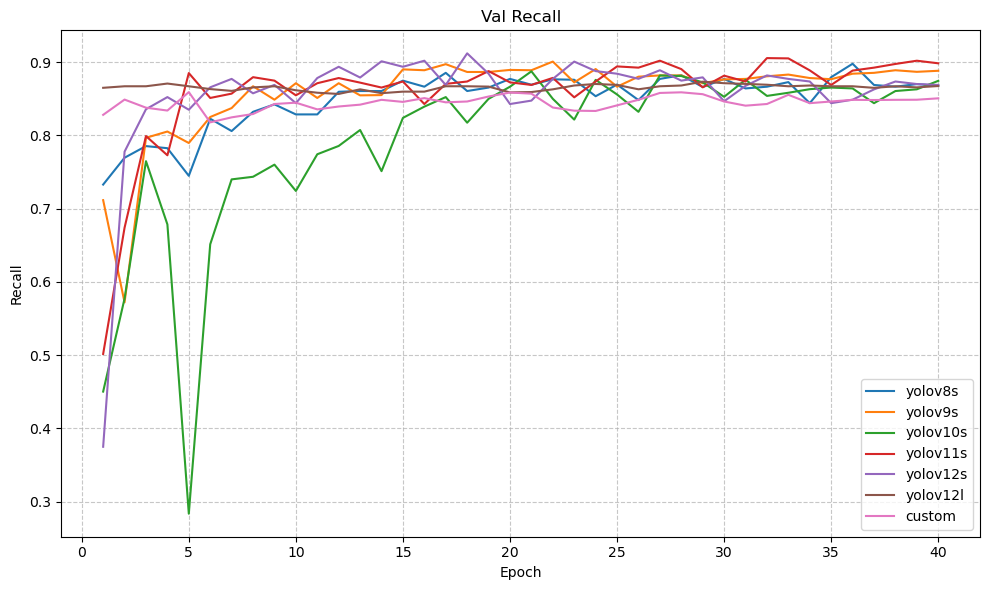

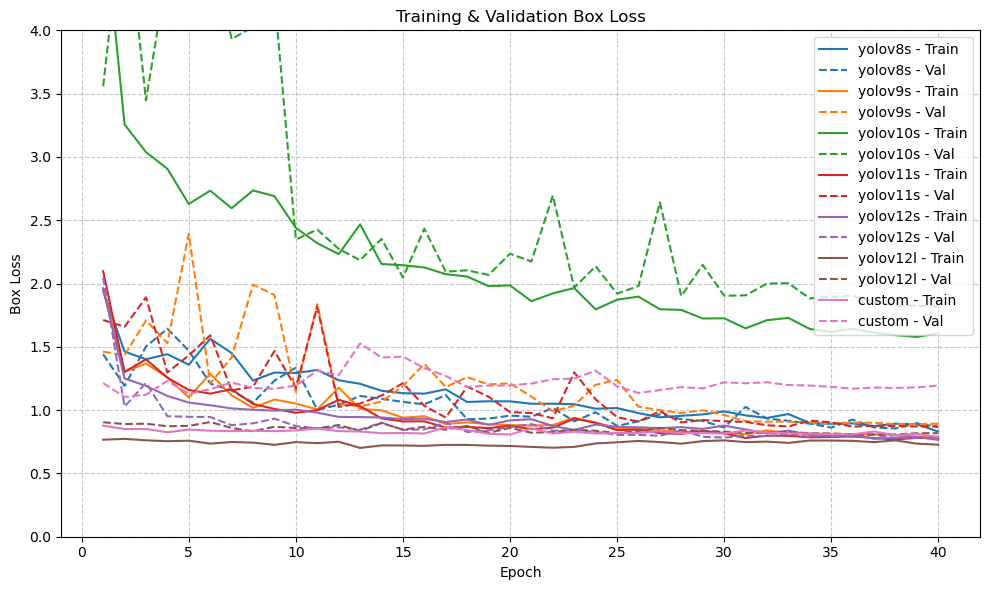

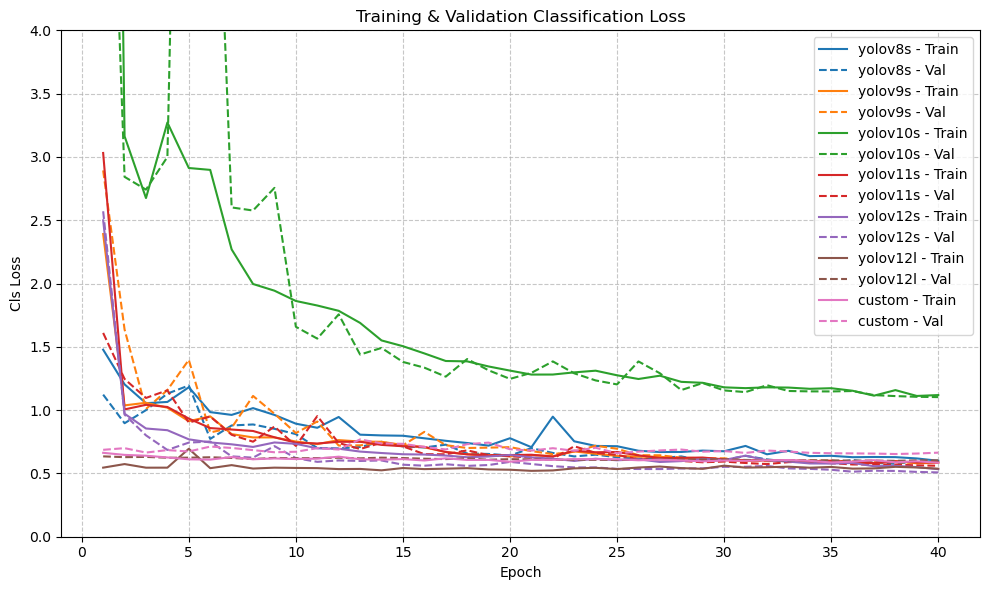

In [3]:
plots_dir = 'yolo/yolo_plots'
dfs = plot_utils.load_experiment_results(config.results_csv_paths)

plot_utils.create_and_save_individual_plot(dfs, plots_dir,'map50-95', 'metrics/mAP50-95(B)', 'Training mAP@0.5:0.95', 'mAP@0.5:0.95')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'map50', 'metrics/mAP50(B)', 'Training mAP@0.5', 'mAP@0.5')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'precision', 'metrics/precision(B)', 'Val Precision', 'Precision')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'recall', 'metrics/recall(B)', 'Val Recall', 'Recall')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'box_loss', ['train/box_loss', 'val/box_loss'], 
                               'Training & Validation Box Loss', 'Box Loss', True, (0, 4))
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'cls_loss', ['train/cls_loss', 'val/cls_loss'], 
                               'Training & Validation Classification Loss', 'Cls Loss', True, (0, 4))

## **Evaluación**

In [3]:
# tests = ["test_original"]
tests = ["original_test", "test", "test2", "test3"]

results = evaluation.evaluate_models(tests=tests, IoU=0.5)

Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1079.4158.3 MB/s, size: 120.7 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\original_test\labels... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<00:00, 586.59it/s]

val: New cache created: ..\03.Datasets\YOLO_Datasets\original_test\labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.58it/s]


                   all         94       1273      0.843      0.844       0.92      0.722
Speed: 1.2ms preprocess, 12.0ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov8s\original_test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov8s\original_test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 856.4151.1 MB/s, size: 107.5 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\original_test\labels.cache... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.02it/s]


                   all         94       1273      0.838      0.852      0.921      0.721
Speed: 1.2ms preprocess, 16.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov9s\original_test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov9s\original_test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 855.3351.1 MB/s, size: 91.4 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\original_test\labels.cache... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.38it/s]


                   all         94       1273      0.821      0.867      0.918      0.717
Speed: 1.3ms preprocess, 12.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov10s\original_test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov10s\original_test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1015.7137.1 MB/s, size: 106.6 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\original_test\labels.cache... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


                   all         94       1273      0.861      0.824      0.921      0.732
Speed: 1.0ms preprocess, 12.7ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov11s\original_test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov11s\original_test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 980.3272.1 MB/s, size: 119.2 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\original_test\labels.cache... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.58it/s]


                   all         94       1273      0.856      0.863      0.936      0.761
Speed: 1.2ms preprocess, 17.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov12s\original_test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov12s\original_test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12l summary (fused): 283 layers, 26,339,843 parameters, 0 gradients, 88.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 962.050.8 MB/s, size: 102.2 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\original_test\labels.cache... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]


                   all         94       1273      0.856      0.836      0.921      0.729
Speed: 1.0ms preprocess, 48.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov12l\original_test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov12l\original_test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
custom summary (fused): 95 layers, 11,139,539 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1019.659.4 MB/s, size: 101.2 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\original_test\labels.cache... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.56it/s]


                   all         94       1273      0.835      0.838      0.909      0.695
Speed: 0.9ms preprocess, 13.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\custom\original_test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\custom\original_test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 817.0337.7 MB/s, size: 85.4 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 94 images, 6 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.45it/s]


                   all         94       1412      0.855      0.838      0.926      0.704
Speed: 1.1ms preprocess, 11.8ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov8s\test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov8s\test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 803.8348.4 MB/s, size: 85.3 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 94 images, 6 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.50it/s]


                   all         94       1412      0.851      0.876      0.933      0.706
Speed: 0.6ms preprocess, 13.5ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov9s\test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov9s\test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1018.8459.7 MB/s, size: 99.6 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 94 images, 6 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  8.06it/s]


                   all         94       1412      0.851      0.862      0.927      0.701
Speed: 1.4ms preprocess, 11.1ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov10s\test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov10s\test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 504.2357.6 MB/s, size: 59.9 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 94 images, 6 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.18it/s]


                   all         94       1412      0.846      0.866       0.93      0.716
Speed: 0.8ms preprocess, 12.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov11s\test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov11s\test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 974.9100.6 MB/s, size: 94.2 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 94 images, 6 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.78it/s]


                   all         94       1412      0.862      0.848      0.936       0.74
Speed: 0.8ms preprocess, 14.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov12s\test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov12s\test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12l summary (fused): 283 layers, 26,339,843 parameters, 0 gradients, 88.5 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 874.9363.3 MB/s, size: 94.3 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 94 images, 6 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


                   all         94       1412      0.846      0.889      0.934      0.714
Speed: 0.8ms preprocess, 45.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov12l\test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov12l\test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
custom summary (fused): 95 layers, 11,139,539 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 907.2130.5 MB/s, size: 92.9 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 94 images, 6 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.01it/s]


                   all         94       1412      0.845      0.853      0.919      0.678
Speed: 0.8ms preprocess, 12.9ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\custom\test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\custom\test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 784.9155.0 MB/s, size: 99.0 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.58s/it]


                   all         10        144      0.924      0.938      0.969      0.553
Speed: 9.2ms preprocess, 30.9ms inference, 0.1ms loss, 5.9ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov8s\test2
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov8s\test2\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 968.4145.4 MB/s, size: 104.1 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


                   all         10        144      0.917      0.927      0.961      0.542
Speed: 8.8ms preprocess, 46.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov9s\test2
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov9s\test2\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1009.3216.1 MB/s, size: 108.7 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


                   all         10        144      0.956      0.898      0.962      0.589
Speed: 6.2ms preprocess, 34.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov10s\test2
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov10s\test2\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1051.9130.7 MB/s, size: 111.7 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


                   all         10        144      0.929      0.917      0.964      0.534
Speed: 7.1ms preprocess, 33.1ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov11s\test2
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov11s\test2\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 708.0130.2 MB/s, size: 102.8 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


                   all         10        144      0.965      0.917      0.975      0.556
Speed: 2.2ms preprocess, 51.5ms inference, 0.1ms loss, 3.5ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov12s\test2
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov12s\test2\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12l summary (fused): 283 layers, 26,339,843 parameters, 0 gradients, 88.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 860.3121.6 MB/s, size: 101.4 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]


                   all         10        144      0.957      0.926      0.975      0.562
Speed: 2.9ms preprocess, 75.9ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov12l\test2
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov12l\test2\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
custom summary (fused): 95 layers, 11,139,539 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 922.9111.4 MB/s, size: 94.5 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


                   all         10        144      0.945      0.903      0.957      0.539
Speed: 2.9ms preprocess, 35.6ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\custom\test2
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\custom\test2\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1550.3309.9 MB/s, size: 217.3 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]


                   all         59       1135      0.842      0.862      0.937        0.7
Speed: 1.7ms preprocess, 12.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov8s\test3
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov8s\test3\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1516.3277.9 MB/s, size: 280.8 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


                   all         59       1135      0.843       0.87      0.935       0.68
Speed: 1.9ms preprocess, 14.8ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov9s\test3
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov9s\test3\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1364.3163.6 MB/s, size: 250.7 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]


                   all         59       1135      0.873      0.826      0.926      0.668
Speed: 1.8ms preprocess, 11.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov10s\test3
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov10s\test3\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2186.4134.2 MB/s, size: 273.7 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.93it/s]


                   all         59       1135      0.855      0.874      0.935      0.698
Speed: 1.3ms preprocess, 10.9ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov11s\test3
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov11s\test3\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2220.2311.3 MB/s, size: 284.2 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


                   all         59       1135      0.836      0.821      0.922      0.723
Speed: 1.4ms preprocess, 15.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov12s\test3
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov12s\test3\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12l summary (fused): 283 layers, 26,339,843 parameters, 0 gradients, 88.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1922.7478.3 MB/s, size: 237.2 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


                   all         59       1135      0.849      0.894      0.942      0.701
Speed: 1.3ms preprocess, 47.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov12l\test3
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov12l\test3\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
custom summary (fused): 95 layers, 11,139,539 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1648.1544.0 MB/s, size: 216.8 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]


                   all         59       1135      0.873      0.843      0.928       0.66
Speed: 1.9ms preprocess, 11.4ms inference, 0.1ms loss, 3.2ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\custom\test3
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\custom\test3\images


In [4]:
# RESULTADOS CUANDO SE CARGARON LAS ANOTACIONES DE TEST ORIGINAL
df = pd.DataFrame(results)
display(df[df["Test"] == "original_test"])

,Modelo,Test,Precisión,Recall,mAP@0.5,mAP@0.5:0.95,Inferencia_ms
0,yolov8s,original_test,0.843,0.844,0.920,0.722,12.023
1,yolov9s,original_test,0.838,0.852,0.921,0.721,16.165
2,yolov10s,original_test,0.821,0.867,0.918,0.717,12.803
3,yolov11s,original_test,0.861,0.824,0.921,0.732,12.729
4,yolov12s,original_test,0.856,0.863,0.936,0.761,16.985
5,yolov12l,original_test,0.856,0.836,0.921,0.729,48.146
6,custom,original_test,0.835,0.838,0.909,0.695,13.058


In [6]:
# RESULTADOS CUANDO SE CARGARON LAS ANOTACIONES DE TESTS CUSTOM
df = pd.DataFrame(results)
display(df[df["Test"] != "original_test"])

,Modelo,Test,Precisión,Recall,mAP@0.5,mAP@0.5:0.95,Inferencia_ms
7,yolov8s,test,0.855,0.838,0.926,0.704,11.844
8,yolov9s,test,0.851,0.876,0.933,0.706,13.492
9,yolov10s,test,0.851,0.862,0.927,0.701,11.120
10,yolov11s,test,0.846,0.866,0.930,0.716,12.143
11,yolov12s,test,0.862,0.848,0.936,0.740,14.519
12,yolov12l,test,0.846,0.889,0.934,0.714,45.214
13,custom,test,0.845,0.853,0.919,0.678,12.913
14,yolov8s,test2,0.924,0.938,0.969,0.553,30.901
15,yolov9s,test2,0.917,0.927,0.961,0.542,46.502
16,yolov10s,test2,0.956,0.898,0.962,0.589,34.355


In [ ]:
tests = ["original_test", "test", "test2", "test3"]

results_03 = evaluation.evaluate_models(tests=tests, IoU=0.5)


Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 202.137.8 MB/s, size: 99.8 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\original_test\labels.cache... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.38it/s]


                   all         94       1273      0.843      0.844       0.92      0.722
Speed: 0.8ms preprocess, 11.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov8s\original_test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov8s\original_test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 905.9127.6 MB/s, size: 100.9 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\original_test\labels.cache... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.97it/s]


                   all         94       1273      0.838      0.852      0.921      0.721
Speed: 1.0ms preprocess, 20.9ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov9s\original_test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov9s\original_test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1093.176.3 MB/s, size: 111.2 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\original_test\labels.cache... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.58it/s]


                   all         94       1273      0.821      0.867      0.918      0.717
Speed: 1.1ms preprocess, 11.9ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov10s\original_test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov10s\original_test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 735.8238.0 MB/s, size: 101.1 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\original_test\labels.cache... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.52it/s]


                   all         94       1273      0.861      0.824      0.921      0.732
Speed: 0.9ms preprocess, 10.7ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov11s\original_test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov11s\original_test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 553.7288.0 MB/s, size: 80.6 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\original_test\labels.cache... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.35it/s]


                   all         94       1273      0.856      0.863      0.936      0.761
Speed: 0.9ms preprocess, 15.7ms inference, 0.1ms loss, 2.0ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov12s\original_test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov12s\original_test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12l summary (fused): 283 layers, 26,339,843 parameters, 0 gradients, 88.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1044.071.3 MB/s, size: 103.0 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\original_test\labels.cache... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]


                   all         94       1273      0.856      0.836      0.921      0.729
Speed: 1.0ms preprocess, 46.9ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov12l\original_test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov12l\original_test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
custom summary (fused): 95 layers, 11,139,539 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 852.3101.9 MB/s, size: 95.1 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\original_test\labels.cache... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


                   all         94       1273      0.835      0.838      0.909      0.695
Speed: 0.9ms preprocess, 12.5ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\custom\original_test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\custom\original_test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 147.373.5 MB/s, size: 105.3 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 94 images, 6 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.54it/s]


                   all         94       1412      0.855      0.838      0.926      0.704
Speed: 1.1ms preprocess, 11.8ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov8s\test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov8s\test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 974.8189.7 MB/s, size: 106.2 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 94 images, 6 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.07it/s]


                   all         94       1412      0.851      0.876      0.933      0.706
Speed: 1.0ms preprocess, 14.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov9s\test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov9s\test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 828.9401.9 MB/s, size: 81.1 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 94 images, 6 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.99it/s]


                   all         94       1412      0.851      0.862      0.927      0.701
Speed: 1.0ms preprocess, 12.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov10s\test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov10s\test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 900.5307.5 MB/s, size: 98.3 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 94 images, 6 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.07it/s]


                   all         94       1412      0.846      0.866       0.93      0.716
Speed: 1.5ms preprocess, 10.3ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov11s\test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov11s\test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1020.0144.8 MB/s, size: 106.0 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 94 images, 6 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.42it/s]


                   all         94       1412      0.862      0.848      0.936       0.74
Speed: 1.3ms preprocess, 15.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov12s\test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov12s\test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12l summary (fused): 283 layers, 26,339,843 parameters, 0 gradients, 88.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 857.9371.5 MB/s, size: 94.3 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 94 images, 6 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


                   all         94       1412      0.846      0.889      0.934      0.714
Speed: 1.0ms preprocess, 46.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov12l\test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov12l\test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
custom summary (fused): 95 layers, 11,139,539 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 959.9430.6 MB/s, size: 100.7 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\test\labels.cache... 94 images, 6 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.30it/s]


                   all         94       1412      0.845      0.853      0.919      0.678
Speed: 0.9ms preprocess, 10.5ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\custom\test
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\custom\test\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 209.053.1 MB/s, size: 113.7 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.90s/it]


                   all         10        144      0.924      0.938      0.969      0.553
Speed: 0.5ms preprocess, 15.9ms inference, 0.0ms loss, 8.3ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov8s\test2
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov8s\test2\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1084.6153.6 MB/s, size: 107.7 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


                   all         10        144      0.917      0.927      0.961      0.542
Speed: 3.9ms preprocess, 47.5ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov9s\test2
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov9s\test2\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 946.3183.8 MB/s, size: 104.6 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]


                   all         10        144      0.956      0.898      0.962      0.589
Speed: 4.1ms preprocess, 38.6ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov10s\test2
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov10s\test2\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1080.5229.5 MB/s, size: 104.8 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.84s/it]


                   all         10        144      0.929      0.917      0.964      0.534
Speed: 4.5ms preprocess, 46.7ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov11s\test2
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov11s\test2\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 902.9162.8 MB/s, size: 96.5 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]


                   all         10        144      0.965      0.917      0.975      0.556
Speed: 1.2ms preprocess, 51.4ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov12s\test2
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov12s\test2\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12l summary (fused): 283 layers, 26,339,843 parameters, 0 gradients, 88.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 971.0235.1 MB/s, size: 103.5 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


                   all         10        144      0.957      0.926      0.975      0.562
Speed: 2.9ms preprocess, 76.2ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov12l\test2
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov12l\test2\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
custom summary (fused): 95 layers, 11,139,539 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 926.5114.5 MB/s, size: 94.7 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test2\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


                   all         10        144      0.945      0.903      0.957      0.539
Speed: 2.0ms preprocess, 38.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\custom\test2
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\custom\test2\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 337.4115.3 MB/s, size: 238.9 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]


                   all         59       1135      0.842      0.862      0.937        0.7
Speed: 1.9ms preprocess, 15.2ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov8s\test3
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov8s\test3\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2243.3222.4 MB/s, size: 263.8 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.89it/s]


                   all         59       1135      0.843       0.87      0.935       0.68
Speed: 1.4ms preprocess, 14.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov9s\test3
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov9s\test3\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2152.1224.9 MB/s, size: 270.4 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.73it/s]


                   all         59       1135      0.873      0.826      0.926      0.668
Speed: 2.0ms preprocess, 14.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov10s\test3
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov10s\test3\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1008.972.9 MB/s, size: 263.8 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]


                   all         59       1135      0.855      0.874      0.935      0.698
Speed: 1.9ms preprocess, 14.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov11s\test3
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov11s\test3\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2009.5199.4 MB/s, size: 271.0 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]


                   all         59       1135      0.836      0.821      0.922      0.723
Speed: 1.0ms preprocess, 16.3ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov12s\test3
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov12s\test3\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12l summary (fused): 283 layers, 26,339,843 parameters, 0 gradients, 88.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1730.4387.3 MB/s, size: 237.4 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]


                   all         59       1135      0.849      0.894      0.942      0.701
Speed: 1.0ms preprocess, 46.6ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\yolov12l\test3
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\yolov12l\test3\images
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
custom summary (fused): 95 layers, 11,139,539 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2095.096.0 MB/s, size: 282.6 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test3\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]


                   all         59       1135      0.873      0.843      0.928       0.66
Speed: 1.3ms preprocess, 13.6ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to ..\08.Resultados Experimentacion\custom\test3
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
Results saved to ..\08.Resultados Experimentacion\custom\test3\images


In [8]:
df = pd.DataFrame(results_03)
df

,Modelo,Test,Precisión,Recall,mAP@0.5,mAP@0.5:0.95,Inferencia_ms
0,yolov8s,original_test,0.843,0.844,0.920,0.722,11.230
1,yolov9s,original_test,0.838,0.852,0.921,0.721,20.871
2,yolov10s,original_test,0.821,0.867,0.918,0.717,11.904
3,yolov11s,original_test,0.861,0.824,0.921,0.732,10.711
4,yolov12s,original_test,0.856,0.863,0.936,0.761,15.699
5,yolov12l,original_test,0.856,0.836,0.921,0.729,46.915
6,custom,original_test,0.835,0.838,0.909,0.695,12.467
7,yolov8s,test,0.855,0.838,0.926,0.704,11.764
8,yolov9s,test,0.851,0.876,0.933,0.706,14.026
9,yolov10s,test,0.851,0.862,0.927,0.701,12.403


| Modelo/Umbral     | 59 imagen | 61 imagen | 219 imagen | 369 imagen | already tested-00 | already tested-15 | already tested-16 | already tested-17 | already tested-22 |
|-------------------|:---------:|:---------:|:---------:|:---------:|:-----------------:|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| Test              |     1     |     1     |     1     |     1     |         3         |         3         |         3         |         3         |         3         |
| yolov8s 0.5       |     ❌    |     ❌    |     ❌    |     ✅    |        ✅         |        ✅         |        ✅         |        ✅         |        ✅         |
| yolov8s 0.7       |     ✅    |     ✅    |     ✅    |     ✅    |        ✅         |        ✅         |        ✅         |        ✅         |        ✅         |
| yolov9s 0.5       |     ❌    |     ❌    |     ❌    |     ❌    |        ✅         |        ❌         |        ❌         |        ✅         |        ✅         |
| yolov9s 0.7       |     ✅    |     ❌    |     ❌    |     ❌    |        ✅         |        ❌         |        ✅         |        ✅         |        ✅         |
| yolov10s 0.5      |     ❌    |     ✅    |     ✅    |     ✅    |        ✅         |        ✅         |        ✅         |        ✅         |        ❌         |
| yolov10s 0.7      |     ✅    |     ✅    |     ✅    |     ✅    |        ✅         |        ✅         |        ✅         |        ✅         |        ✅         |
| yolov11s 0.5      |     ✅    |     ❌    |     ❌    |     ❌    |        ✅         |        ❌         |        ✅         |        ✅         |        ✅         |
| yolov11s 0.7      |     ✅    |     ✅    |     ✅    |     ✅    |        ✅         |        ✅         |        ✅         |        ✅         |        ✅         |
| yolov12s 0.5      |     ✅    |     ✅    |     ✅    |     ✅    |        ✅         |        ✅         |        ✅         |        ✅         |        ✅         |
| yolov12s 0.7      |     ✅    |     ✅    |     ✅    |     ✅    |        ✅         |        ✅         |        ✅         |        ✅         |        ✅         |
| yolov12l 0.5      |           |           |           |           |                   |                   |                   |                   |                   |
| yolov12l 0.7      |           |           |           |           |                   |                   |                   |                   |                   |
| custom 0.5        |           |           |           |           |                   |                   |                   |                   |                   |
| custom 0.7        |           |           |           |           |                   |                   |                   |                   |                   |
| ensemble 0.5      |           |           |           |           |                   |                   |                   |                   |                   |
| ensemble 0.7      |           |           |           |           |                   |                   |                   |                   |                   |

## **Conclusión**

## **Comentarios reunión semanal**

Para el power point usar el mes gratis de copilot, así lo redacto mejor y más rápido la presentación

"no es posible distinguir entre leucocitos y células germinales inmaduras con un alto grado de certeza (2)" https://pmc.ncbi.nlm.nih.gov/articles/PMC8915675/

Quiero probar este modelo: https://github.com/Peterande/D-FINE?tab=readme-ov-file